In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "400X"
trainable_blocks = ["block4"]
irun = 1


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_400X-BREAKHIS-Dataset-60-10-30-VGGINet/1'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/400X/1'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 971 files belonging to 2 classes.


Found 161 files belonging to 2 classes.


Found 488 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/8 [==>...........................] - ETA: 0s - loss: 1.3477 - accuracy: 0.4922

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/8 [======>.......................] - ETA: 7s - loss: 3.9219 - accuracy: 0.6055

3/8 [==========>...................] - ETA: 6s - loss: 4.6094 - accuracy: 0.6562

4/8 [==============>...............] - ETA: 5s - loss: 4.7404 - accuracy: 0.6660

5/8 [=================>............] - ETA: 3s - loss: 4.7756 - accuracy: 0.6672

6/8 [=====================>........] - ETA: 2s - loss: 4.2652 - accuracy: 0.6927

7/8 [=========================>....] - ETA: 1s - loss: 3.8163 - accuracy: 0.7210

8/8 [==============================] - ETA: 0s - loss: 3.6958 - accuracy: 0.7302

8/8 [==============================] - 29s 4s/step - loss: 3.6958 - accuracy: 0.7302 - val_loss: 10.1443 - val_accuracy: 0.8323


Epoch 2/100


1/8 [==>...........................] - ETA: 0s - loss: 3.9687 - accuracy: 0.8203

2/8 [======>.......................] - ETA: 3s - loss: 3.3723 - accuracy: 0.8281

3/8 [==========>...................] - ETA: 3s - loss: 2.9039 - accuracy: 0.8464

4/8 [==============>...............] - ETA: 4s - loss: 2.6728 - accuracy: 0.8516

5/8 [=================>............] - ETA: 3s - loss: 2.5848 - accuracy: 0.8516

6/8 [=====================>........] - ETA: 2s - loss: 2.4830 - accuracy: 0.8464

7/8 [=========================>....] - ETA: 1s - loss: 2.3395 - accuracy: 0.8471

8/8 [==============================] - ETA: 0s - loss: 2.3675 - accuracy: 0.8414

8/8 [==============================] - 11s 1s/step - loss: 2.3675 - accuracy: 0.8414 - val_loss: 4.8003 - val_accuracy: 0.8634


Epoch 3/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4753 - accuracy: 0.8672

2/8 [======>.......................] - ETA: 11s - loss: 1.5297 - accuracy: 0.8633

3/8 [==========>...................] - ETA: 8s - loss: 1.6105 - accuracy: 0.8516 

4/8 [==============>...............] - ETA: 7s - loss: 1.4808 - accuracy: 0.8574

5/8 [=================>............] - ETA: 5s - loss: 1.4042 - accuracy: 0.8578

6/8 [=====================>........] - ETA: 3s - loss: 1.4289 - accuracy: 0.8620

7/8 [=========================>....] - ETA: 1s - loss: 1.4186 - accuracy: 0.8605

8/8 [==============================] - ETA: 0s - loss: 1.3844 - accuracy: 0.8641

8/8 [==============================] - 14s 2s/step - loss: 1.3844 - accuracy: 0.8641 - val_loss: 2.1629 - val_accuracy: 0.8758


Epoch 4/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7741 - accuracy: 0.8906

2/8 [======>.......................] - ETA: 12s - loss: 0.7575 - accuracy: 0.9023

3/8 [==========>...................] - ETA: 8s - loss: 0.9671 - accuracy: 0.8932 

4/8 [==============>...............] - ETA: 7s - loss: 1.1222 - accuracy: 0.8887

5/8 [=================>............] - ETA: 4s - loss: 1.1206 - accuracy: 0.8859

6/8 [=====================>........] - ETA: 3s - loss: 1.0401 - accuracy: 0.8854

7/8 [=========================>....] - ETA: 1s - loss: 1.1495 - accuracy: 0.8817

8/8 [==============================] - ETA: 0s - loss: 1.1095 - accuracy: 0.8836

8/8 [==============================] - 14s 2s/step - loss: 1.1095 - accuracy: 0.8836 - val_loss: 4.6517 - val_accuracy: 0.8696


Epoch 5/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0698 - accuracy: 0.9062

2/8 [======>.......................] - ETA: 12s - loss: 0.8904 - accuracy: 0.9062

3/8 [==========>...................] - ETA: 8s - loss: 0.9838 - accuracy: 0.8932 

4/8 [==============>...............] - ETA: 8s - loss: 0.8950 - accuracy: 0.8965

5/8 [=================>............] - ETA: 5s - loss: 0.8557 - accuracy: 0.8938

6/8 [=====================>........] - ETA: 3s - loss: 0.8680 - accuracy: 0.8958

7/8 [=========================>....] - ETA: 1s - loss: 1.0586 - accuracy: 0.8806

8/8 [==============================] - ETA: 0s - loss: 1.1708 - accuracy: 0.8744

8/8 [==============================] - 15s 2s/step - loss: 1.1708 - accuracy: 0.8744 - val_loss: 2.4954 - val_accuracy: 0.8385


Epoch 6/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7574 - accuracy: 0.8672

2/8 [======>.......................] - ETA: 12s - loss: 0.7698 - accuracy: 0.8828

3/8 [==========>...................] - ETA: 8s - loss: 0.9288 - accuracy: 0.8854 

4/8 [==============>...............] - ETA: 8s - loss: 1.0452 - accuracy: 0.8926

5/8 [=================>............] - ETA: 5s - loss: 1.0255 - accuracy: 0.8906

6/8 [=====================>........] - ETA: 3s - loss: 1.0215 - accuracy: 0.8893

7/8 [=========================>....] - ETA: 1s - loss: 1.0027 - accuracy: 0.8929

8/8 [==============================] - ETA: 0s - loss: 1.0954 - accuracy: 0.8888

8/8 [==============================] - 15s 2s/step - loss: 1.0954 - accuracy: 0.8888 - val_loss: 1.1938 - val_accuracy: 0.9317


Epoch 7/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2996 - accuracy: 0.8750

2/8 [======>.......................] - ETA: 12s - loss: 1.0871 - accuracy: 0.8906

3/8 [==========>...................] - ETA: 9s - loss: 0.9357 - accuracy: 0.9036 

4/8 [==============>...............] - ETA: 8s - loss: 1.0458 - accuracy: 0.8945

5/8 [=================>............] - ETA: 5s - loss: 1.1409 - accuracy: 0.8875

6/8 [=====================>........] - ETA: 3s - loss: 1.1585 - accuracy: 0.8763

7/8 [=========================>....] - ETA: 1s - loss: 1.1817 - accuracy: 0.8772

8/8 [==============================] - ETA: 0s - loss: 1.1948 - accuracy: 0.8774

8/8 [==============================] - 15s 2s/step - loss: 1.1948 - accuracy: 0.8774 - val_loss: 1.2795 - val_accuracy: 0.9255


Epoch 8/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2537 - accuracy: 0.8672

2/8 [======>.......................] - ETA: 11s - loss: 1.3974 - accuracy: 0.8594

3/8 [==========>...................] - ETA: 8s - loss: 1.5174 - accuracy: 0.8542 

4/8 [==============>...............] - ETA: 7s - loss: 1.6307 - accuracy: 0.8535

5/8 [=================>............] - ETA: 5s - loss: 1.5866 - accuracy: 0.8578

6/8 [=====================>........] - ETA: 3s - loss: 1.4547 - accuracy: 0.8607

7/8 [=========================>....] - ETA: 1s - loss: 1.3204 - accuracy: 0.8717

8/8 [==============================] - ETA: 0s - loss: 1.3223 - accuracy: 0.8744

8/8 [==============================] - 14s 2s/step - loss: 1.3223 - accuracy: 0.8744 - val_loss: 0.9002 - val_accuracy: 0.9441


Epoch 9/100


1/8 [==>...........................] - ETA: 0s - loss: 1.9252 - accuracy: 0.8906

2/8 [======>.......................] - ETA: 11s - loss: 1.3368 - accuracy: 0.9141

3/8 [==========>...................] - ETA: 8s - loss: 1.2883 - accuracy: 0.9062 

4/8 [==============>...............] - ETA: 7s - loss: 1.3977 - accuracy: 0.9023

5/8 [=================>............] - ETA: 5s - loss: 1.5293 - accuracy: 0.8891

6/8 [=====================>........] - ETA: 3s - loss: 1.5772 - accuracy: 0.8815

7/8 [=========================>....] - ETA: 1s - loss: 1.4688 - accuracy: 0.8862

8/8 [==============================] - ETA: 0s - loss: 1.4176 - accuracy: 0.8877

8/8 [==============================] - 14s 2s/step - loss: 1.4176 - accuracy: 0.8877 - val_loss: 1.8060 - val_accuracy: 0.9130


Epoch 10/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7284 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 1.2866 - accuracy: 0.9180

3/8 [==========>...................] - ETA: 8s - loss: 1.1417 - accuracy: 0.9271 

4/8 [==============>...............] - ETA: 7s - loss: 1.7771 - accuracy: 0.8926

5/8 [=================>............] - ETA: 4s - loss: 1.6457 - accuracy: 0.8906

6/8 [=====================>........] - ETA: 3s - loss: 1.6296 - accuracy: 0.8932

7/8 [=========================>....] - ETA: 1s - loss: 1.5200 - accuracy: 0.8962

8/8 [==============================] - ETA: 0s - loss: 1.5405 - accuracy: 0.8970

8/8 [==============================] - 14s 2s/step - loss: 1.5405 - accuracy: 0.8970 - val_loss: 1.7219 - val_accuracy: 0.8882


Epoch 11/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6353 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 11s - loss: 1.2910 - accuracy: 0.8867

3/8 [==========>...................] - ETA: 10s - loss: 1.2940 - accuracy: 0.8828

4/8 [==============>...............] - ETA: 7s - loss: 1.1358 - accuracy: 0.8945 

5/8 [=================>............] - ETA: 5s - loss: 1.3139 - accuracy: 0.8891

6/8 [=====================>........] - ETA: 3s - loss: 1.5110 - accuracy: 0.8841

7/8 [=========================>....] - ETA: 1s - loss: 1.4818 - accuracy: 0.8839

8/8 [==============================] - ETA: 0s - loss: 1.4647 - accuracy: 0.8847

8/8 [==============================] - 14s 2s/step - loss: 1.4647 - accuracy: 0.8847 - val_loss: 1.6986 - val_accuracy: 0.9193


Epoch 12/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0720 - accuracy: 0.8750

2/8 [======>.......................] - ETA: 11s - loss: 1.4368 - accuracy: 0.8789

3/8 [==========>...................] - ETA: 11s - loss: 1.2758 - accuracy: 0.8854

4/8 [==============>...............] - ETA: 7s - loss: 1.2692 - accuracy: 0.8926 

5/8 [=================>............] - ETA: 5s - loss: 1.2233 - accuracy: 0.8969

6/8 [=====================>........] - ETA: 3s - loss: 1.2206 - accuracy: 0.8971

7/8 [=========================>....] - ETA: 1s - loss: 1.3673 - accuracy: 0.8929

8/8 [==============================] - ETA: 0s - loss: 1.4112 - accuracy: 0.8929

8/8 [==============================] - 14s 2s/step - loss: 1.4112 - accuracy: 0.8929 - val_loss: 1.2782 - val_accuracy: 0.9317


Epoch 13/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1110 - accuracy: 0.9141

2/8 [======>.......................] - ETA: 11s - loss: 1.4766 - accuracy: 0.8945

3/8 [==========>...................] - ETA: 8s - loss: 1.4849 - accuracy: 0.8802 

4/8 [==============>...............] - ETA: 7s - loss: 1.4756 - accuracy: 0.8848

5/8 [=================>............] - ETA: 5s - loss: 1.4818 - accuracy: 0.8844

6/8 [=====================>........] - ETA: 3s - loss: 1.4111 - accuracy: 0.8919

7/8 [=========================>....] - ETA: 1s - loss: 1.2845 - accuracy: 0.8973

8/8 [==============================] - ETA: 0s - loss: 1.2835 - accuracy: 0.8960

8/8 [==============================] - 14s 2s/step - loss: 1.2835 - accuracy: 0.8960 - val_loss: 1.2859 - val_accuracy: 0.9193


Epoch 14/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0001 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 0.7928 - accuracy: 0.9375

3/8 [==========>...................] - ETA: 8s - loss: 0.8716 - accuracy: 0.9323 

4/8 [==============>...............] - ETA: 7s - loss: 1.1202 - accuracy: 0.9160

5/8 [=================>............] - ETA: 4s - loss: 1.1372 - accuracy: 0.9078

6/8 [=====================>........] - ETA: 3s - loss: 1.0472 - accuracy: 0.9089

7/8 [=========================>....] - ETA: 1s - loss: 1.0723 - accuracy: 0.9085

8/8 [==============================] - ETA: 0s - loss: 1.0327 - accuracy: 0.9104

8/8 [==============================] - 14s 2s/step - loss: 1.0327 - accuracy: 0.9104 - val_loss: 1.6294 - val_accuracy: 0.9068


Epoch 15/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9699 - accuracy: 0.8906

2/8 [======>.......................] - ETA: 11s - loss: 0.9808 - accuracy: 0.8789

3/8 [==========>...................] - ETA: 8s - loss: 1.1074 - accuracy: 0.8828 

4/8 [==============>...............] - ETA: 8s - loss: 1.1855 - accuracy: 0.8828

5/8 [=================>............] - ETA: 5s - loss: 1.0248 - accuracy: 0.8969

6/8 [=====================>........] - ETA: 3s - loss: 0.9906 - accuracy: 0.8971

7/8 [=========================>....] - ETA: 1s - loss: 1.0265 - accuracy: 0.9018

8/8 [==============================] - ETA: 0s - loss: 0.9836 - accuracy: 0.9053

8/8 [==============================] - 14s 2s/step - loss: 0.9836 - accuracy: 0.9053 - val_loss: 1.6493 - val_accuracy: 0.8882


Epoch 16/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7450 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 1.1699 - accuracy: 0.9102

3/8 [==========>...................] - ETA: 8s - loss: 1.1402 - accuracy: 0.9036 

4/8 [==============>...............] - ETA: 7s - loss: 1.0543 - accuracy: 0.9043

5/8 [=================>............] - ETA: 4s - loss: 1.1035 - accuracy: 0.8969

6/8 [=====================>........] - ETA: 3s - loss: 1.0488 - accuracy: 0.9023

7/8 [=========================>....] - ETA: 1s - loss: 0.9886 - accuracy: 0.9029

8/8 [==============================] - ETA: 0s - loss: 0.9794 - accuracy: 0.9042

8/8 [==============================] - 14s 2s/step - loss: 0.9794 - accuracy: 0.9042 - val_loss: 1.4041 - val_accuracy: 0.9130


Epoch 17/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9204 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 4s - loss: 0.8814 - accuracy: 0.9219

3/8 [==========>...................] - ETA: 8s - loss: 1.0397 - accuracy: 0.9141

4/8 [==============>...............] - ETA: 8s - loss: 1.0028 - accuracy: 0.9160

5/8 [=================>............] - ETA: 5s - loss: 1.0704 - accuracy: 0.9062

6/8 [=====================>........] - ETA: 3s - loss: 1.0318 - accuracy: 0.9128

7/8 [=========================>....] - ETA: 1s - loss: 1.0193 - accuracy: 0.9129

8/8 [==============================] - ETA: 0s - loss: 1.0533 - accuracy: 0.9125

8/8 [==============================] - 15s 2s/step - loss: 1.0533 - accuracy: 0.9125 - val_loss: 1.4516 - val_accuracy: 0.9068


Epoch 18/100


1/8 [==>...........................] - ETA: 0s - loss: 2.0029 - accuracy: 0.8906

2/8 [======>.......................] - ETA: 11s - loss: 1.3922 - accuracy: 0.9062

3/8 [==========>...................] - ETA: 8s - loss: 1.1840 - accuracy: 0.9115 

4/8 [==============>...............] - ETA: 7s - loss: 1.1868 - accuracy: 0.9082

5/8 [=================>............] - ETA: 4s - loss: 1.0508 - accuracy: 0.9156

6/8 [=====================>........] - ETA: 3s - loss: 1.0934 - accuracy: 0.9167

7/8 [=========================>....] - ETA: 1s - loss: 0.9964 - accuracy: 0.9208

8/8 [==============================] - ETA: 0s - loss: 0.9590 - accuracy: 0.9238

8/8 [==============================] - 14s 2s/step - loss: 0.9590 - accuracy: 0.9238 - val_loss: 1.1926 - val_accuracy: 0.8944


Epoch 19/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1279 - accuracy: 0.9141

2/8 [======>.......................] - ETA: 12s - loss: 1.2414 - accuracy: 0.9023

3/8 [==========>...................] - ETA: 8s - loss: 1.1276 - accuracy: 0.9141 

4/8 [==============>...............] - ETA: 8s - loss: 1.0541 - accuracy: 0.9219

5/8 [=================>............] - ETA: 5s - loss: 1.1680 - accuracy: 0.9172

6/8 [=====================>........] - ETA: 3s - loss: 1.0864 - accuracy: 0.9219

7/8 [=========================>....] - ETA: 1s - loss: 1.0554 - accuracy: 0.9185

8/8 [==============================] - ETA: 0s - loss: 0.9920 - accuracy: 0.9228

8/8 [==============================] - 15s 2s/step - loss: 0.9920 - accuracy: 0.9228 - val_loss: 1.2901 - val_accuracy: 0.8882


Epoch 20/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7892 - accuracy: 0.8906

2/8 [======>.......................] - ETA: 12s - loss: 0.8254 - accuracy: 0.9141

3/8 [==========>...................] - ETA: 8s - loss: 0.7433 - accuracy: 0.9219 

4/8 [==============>...............] - ETA: 7s - loss: 0.7646 - accuracy: 0.9277

5/8 [=================>............] - ETA: 5s - loss: 0.7835 - accuracy: 0.9297

6/8 [=====================>........] - ETA: 3s - loss: 0.8738 - accuracy: 0.9271

7/8 [=========================>....] - ETA: 1s - loss: 0.9011 - accuracy: 0.9241

8/8 [==============================] - ETA: 0s - loss: 0.9347 - accuracy: 0.9238

8/8 [==============================] - 14s 2s/step - loss: 0.9347 - accuracy: 0.9238 - val_loss: 1.6724 - val_accuracy: 0.8696


Epoch 21/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4077 - accuracy: 0.9062

2/8 [======>.......................] - ETA: 11s - loss: 1.4396 - accuracy: 0.9102

3/8 [==========>...................] - ETA: 8s - loss: 1.3585 - accuracy: 0.9062 

4/8 [==============>...............] - ETA: 8s - loss: 1.3485 - accuracy: 0.9141

5/8 [=================>............] - ETA: 5s - loss: 1.2435 - accuracy: 0.9187

6/8 [=====================>........] - ETA: 3s - loss: 1.3151 - accuracy: 0.9193

7/8 [=========================>....] - ETA: 1s - loss: 1.2249 - accuracy: 0.9208

8/8 [==============================] - ETA: 0s - loss: 1.2279 - accuracy: 0.9217

8/8 [==============================] - 14s 2s/step - loss: 1.2279 - accuracy: 0.9217 - val_loss: 1.3763 - val_accuracy: 0.8882


Epoch 22/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1724 - accuracy: 0.9062

2/8 [======>.......................] - ETA: 12s - loss: 0.7982 - accuracy: 0.9258

3/8 [==========>...................] - ETA: 8s - loss: 0.7988 - accuracy: 0.9297 

4/8 [==============>...............] - ETA: 7s - loss: 0.8791 - accuracy: 0.9277

5/8 [=================>............] - ETA: 4s - loss: 0.9345 - accuracy: 0.9219

6/8 [=====================>........] - ETA: 3s - loss: 0.8880 - accuracy: 0.9232

7/8 [=========================>....] - ETA: 1s - loss: 0.9067 - accuracy: 0.9241

8/8 [==============================] - ETA: 0s - loss: 0.8992 - accuracy: 0.9279

8/8 [==============================] - 14s 2s/step - loss: 0.8992 - accuracy: 0.9279 - val_loss: 1.1222 - val_accuracy: 0.9006


Epoch 23/100


1/8 [==>...........................] - ETA: 0s - loss: 2.0205 - accuracy: 0.8906

2/8 [======>.......................] - ETA: 11s - loss: 1.5966 - accuracy: 0.9062

3/8 [==========>...................] - ETA: 8s - loss: 1.3109 - accuracy: 0.9089 

4/8 [==============>...............] - ETA: 7s - loss: 1.2080 - accuracy: 0.9141

5/8 [=================>............] - ETA: 4s - loss: 1.0774 - accuracy: 0.9219

6/8 [=====================>........] - ETA: 3s - loss: 1.0179 - accuracy: 0.9284

7/8 [=========================>....] - ETA: 1s - loss: 0.9721 - accuracy: 0.9275

8/8 [==============================] - ETA: 0s - loss: 0.9858 - accuracy: 0.9269

8/8 [==============================] - 14s 2s/step - loss: 0.9858 - accuracy: 0.9269 - val_loss: 1.4178 - val_accuracy: 0.9130


Epoch 24/100


1/8 [==>...........................] - ETA: 0s - loss: 1.0979 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 1.2783 - accuracy: 0.9141

3/8 [==========>...................] - ETA: 8s - loss: 0.9874 - accuracy: 0.9323 

4/8 [==============>...............] - ETA: 7s - loss: 1.0042 - accuracy: 0.9336

5/8 [=================>............] - ETA: 4s - loss: 0.9110 - accuracy: 0.9312

6/8 [=====================>........] - ETA: 2s - loss: 0.9294 - accuracy: 0.9323

7/8 [=========================>....] - ETA: 1s - loss: 0.8372 - accuracy: 0.9375

8/8 [==============================] - ETA: 0s - loss: 0.8931 - accuracy: 0.9351

8/8 [==============================] - 14s 2s/step - loss: 0.8931 - accuracy: 0.9351 - val_loss: 1.1077 - val_accuracy: 0.9317


Epoch 25/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1607 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 12s - loss: 0.9986 - accuracy: 0.9375

3/8 [==========>...................] - ETA: 8s - loss: 0.7518 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 7s - loss: 0.9067 - accuracy: 0.9316

5/8 [=================>............] - ETA: 4s - loss: 0.8215 - accuracy: 0.9328

6/8 [=====================>........] - ETA: 3s - loss: 0.8614 - accuracy: 0.9323

7/8 [=========================>....] - ETA: 1s - loss: 0.8908 - accuracy: 0.9286

8/8 [==============================] - ETA: 0s - loss: 0.8430 - accuracy: 0.9320

8/8 [==============================] - 14s 2s/step - loss: 0.8430 - accuracy: 0.9320 - val_loss: 1.5144 - val_accuracy: 0.9006


Epoch 26/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4044 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 2s - loss: 1.1791 - accuracy: 0.9336

3/8 [==========>...................] - ETA: 3s - loss: 0.9015 - accuracy: 0.9323

4/8 [==============>...............] - ETA: 4s - loss: 0.8012 - accuracy: 0.9258

5/8 [=================>............] - ETA: 3s - loss: 0.8247 - accuracy: 0.9266

6/8 [=====================>........] - ETA: 2s - loss: 0.9007 - accuracy: 0.9232

7/8 [=========================>....] - ETA: 1s - loss: 0.9704 - accuracy: 0.9241

8/8 [==============================] - ETA: 0s - loss: 0.9645 - accuracy: 0.9217

8/8 [==============================] - 11s 1s/step - loss: 0.9645 - accuracy: 0.9217 - val_loss: 1.2771 - val_accuracy: 0.9130


Epoch 27/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2840 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.4354 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 8s - loss: 0.5692 - accuracy: 0.9323 

4/8 [==============>...............] - ETA: 7s - loss: 0.6411 - accuracy: 0.9277

5/8 [=================>............] - ETA: 5s - loss: 0.6791 - accuracy: 0.9281

6/8 [=====================>........] - ETA: 3s - loss: 0.6934 - accuracy: 0.9284

7/8 [=========================>....] - ETA: 1s - loss: 0.7566 - accuracy: 0.9241

8/8 [==============================] - ETA: 0s - loss: 0.7848 - accuracy: 0.9197

8/8 [==============================] - 14s 2s/step - loss: 0.7848 - accuracy: 0.9197 - val_loss: 1.3354 - val_accuracy: 0.9130


Epoch 28/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1266 - accuracy: 0.8906

2/8 [======>.......................] - ETA: 11s - loss: 0.7801 - accuracy: 0.9258

3/8 [==========>...................] - ETA: 7s - loss: 0.7747 - accuracy: 0.9349 

4/8 [==============>...............] - ETA: 7s - loss: 0.8027 - accuracy: 0.9297

5/8 [=================>............] - ETA: 4s - loss: 0.8685 - accuracy: 0.9297

6/8 [=====================>........] - ETA: 2s - loss: 0.8882 - accuracy: 0.9271

7/8 [=========================>....] - ETA: 1s - loss: 0.8483 - accuracy: 0.9286

8/8 [==============================] - ETA: 0s - loss: 0.9029 - accuracy: 0.9269

8/8 [==============================] - 13s 2s/step - loss: 0.9029 - accuracy: 0.9269 - val_loss: 3.8168 - val_accuracy: 0.8758


Epoch 29/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2540 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.2886 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 8s - loss: 0.4624 - accuracy: 0.9531 

4/8 [==============>...............] - ETA: 7s - loss: 0.7132 - accuracy: 0.9355

5/8 [=================>............] - ETA: 5s - loss: 0.6276 - accuracy: 0.9406

6/8 [=====================>........] - ETA: 3s - loss: 0.6516 - accuracy: 0.9375

7/8 [=========================>....] - ETA: 1s - loss: 0.6387 - accuracy: 0.9386

8/8 [==============================] - ETA: 0s - loss: 0.7070 - accuracy: 0.9351

8/8 [==============================] - 14s 2s/step - loss: 0.7070 - accuracy: 0.9351 - val_loss: 1.5209 - val_accuracy: 0.9068


Epoch 30/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4186 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.6366 - accuracy: 0.9375

3/8 [==========>...................] - ETA: 10s - loss: 0.5653 - accuracy: 0.9427

4/8 [==============>...............] - ETA: 7s - loss: 0.7390 - accuracy: 0.9414 

5/8 [=================>............] - ETA: 4s - loss: 0.7050 - accuracy: 0.9453

6/8 [=====================>........] - ETA: 3s - loss: 0.7681 - accuracy: 0.9401

7/8 [=========================>....] - ETA: 1s - loss: 0.7761 - accuracy: 0.9386

8/8 [==============================] - ETA: 0s - loss: 0.7419 - accuracy: 0.9403

8/8 [==============================] - 14s 2s/step - loss: 0.7419 - accuracy: 0.9403 - val_loss: 1.7935 - val_accuracy: 0.9130


Epoch 31/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1690 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 11s - loss: 0.9488 - accuracy: 0.9375

3/8 [==========>...................] - ETA: 8s - loss: 0.7611 - accuracy: 0.9427 

4/8 [==============>...............] - ETA: 7s - loss: 0.6061 - accuracy: 0.9531

5/8 [=================>............] - ETA: 4s - loss: 0.5864 - accuracy: 0.9547

6/8 [=====================>........] - ETA: 3s - loss: 0.5520 - accuracy: 0.9518

7/8 [=========================>....] - ETA: 1s - loss: 0.5081 - accuracy: 0.9554

8/8 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.9547

8/8 [==============================] - 14s 2s/step - loss: 0.5294 - accuracy: 0.9547 - val_loss: 1.8633 - val_accuracy: 0.9255


Epoch 32/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5603 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 0.7441 - accuracy: 0.9219

3/8 [==========>...................] - ETA: 8s - loss: 0.6768 - accuracy: 0.9245 

4/8 [==============>...............] - ETA: 7s - loss: 0.5447 - accuracy: 0.9336

5/8 [=================>............] - ETA: 5s - loss: 0.6913 - accuracy: 0.9312

6/8 [=====================>........] - ETA: 3s - loss: 0.7546 - accuracy: 0.9310

7/8 [=========================>....] - ETA: 1s - loss: 0.7048 - accuracy: 0.9330

8/8 [==============================] - ETA: 0s - loss: 0.7324 - accuracy: 0.9310

8/8 [==============================] - 14s 2s/step - loss: 0.7324 - accuracy: 0.9310 - val_loss: 1.3358 - val_accuracy: 0.9255


Epoch 33/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4183 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 3s - loss: 0.5822 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 8s - loss: 0.5295 - accuracy: 0.9479

4/8 [==============>...............] - ETA: 5s - loss: 0.5314 - accuracy: 0.9492

5/8 [=================>............] - ETA: 5s - loss: 0.5899 - accuracy: 0.9453

6/8 [=====================>........] - ETA: 3s - loss: 0.5054 - accuracy: 0.9505

7/8 [=========================>....] - ETA: 1s - loss: 0.5051 - accuracy: 0.9520

8/8 [==============================] - ETA: 0s - loss: 0.5179 - accuracy: 0.9516

8/8 [==============================] - 14s 2s/step - loss: 0.5179 - accuracy: 0.9516 - val_loss: 1.8065 - val_accuracy: 0.9193


Epoch 34/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1740 - accuracy: 0.9141

2/8 [======>.......................] - ETA: 12s - loss: 0.8357 - accuracy: 0.9336

3/8 [==========>...................] - ETA: 8s - loss: 0.8111 - accuracy: 0.9245 

4/8 [==============>...............] - ETA: 8s - loss: 0.7906 - accuracy: 0.9297

5/8 [=================>............] - ETA: 5s - loss: 0.6935 - accuracy: 0.9359

6/8 [=====================>........] - ETA: 3s - loss: 0.6973 - accuracy: 0.9362

7/8 [=========================>....] - ETA: 1s - loss: 0.7308 - accuracy: 0.9319

8/8 [==============================] - ETA: 0s - loss: 0.7802 - accuracy: 0.9310

8/8 [==============================] - 14s 2s/step - loss: 0.7802 - accuracy: 0.9310 - val_loss: 1.6738 - val_accuracy: 0.9006


Epoch 35/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8062 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 0.9896 - accuracy: 0.9219

3/8 [==========>...................] - ETA: 8s - loss: 0.9168 - accuracy: 0.9271 

4/8 [==============>...............] - ETA: 7s - loss: 0.8939 - accuracy: 0.9219

5/8 [=================>............] - ETA: 5s - loss: 0.8502 - accuracy: 0.9266

6/8 [=====================>........] - ETA: 3s - loss: 0.7978 - accuracy: 0.9323

7/8 [=========================>....] - ETA: 1s - loss: 0.7385 - accuracy: 0.9342

8/8 [==============================] - ETA: 0s - loss: 0.7152 - accuracy: 0.9361

8/8 [==============================] - 14s 2s/step - loss: 0.7152 - accuracy: 0.9361 - val_loss: 1.7608 - val_accuracy: 0.9255


Epoch 36/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5733 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 12s - loss: 0.7481 - accuracy: 0.9336

3/8 [==========>...................] - ETA: 8s - loss: 0.7742 - accuracy: 0.9323 

4/8 [==============>...............] - ETA: 7s - loss: 0.8430 - accuracy: 0.9258

5/8 [=================>............] - ETA: 5s - loss: 0.7129 - accuracy: 0.9344

6/8 [=====================>........] - ETA: 3s - loss: 0.6973 - accuracy: 0.9310

7/8 [=========================>....] - ETA: 1s - loss: 0.6192 - accuracy: 0.9353

8/8 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.9351

8/8 [==============================] - 14s 2s/step - loss: 0.6758 - accuracy: 0.9351 - val_loss: 1.8889 - val_accuracy: 0.9130


Epoch 37/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0832 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 12s - loss: 0.6084 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 8s - loss: 0.7162 - accuracy: 0.9557 

4/8 [==============>...............] - ETA: 7s - loss: 0.6825 - accuracy: 0.9590

5/8 [=================>............] - ETA: 5s - loss: 0.7164 - accuracy: 0.9578

6/8 [=====================>........] - ETA: 3s - loss: 0.7120 - accuracy: 0.9557

7/8 [=========================>....] - ETA: 1s - loss: 0.6883 - accuracy: 0.9498

8/8 [==============================] - ETA: 0s - loss: 0.7105 - accuracy: 0.9485

8/8 [==============================] - 14s 2s/step - loss: 0.7105 - accuracy: 0.9485 - val_loss: 2.2460 - val_accuracy: 0.9130


Epoch 38/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5631 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 13s - loss: 0.4280 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 9s - loss: 0.4452 - accuracy: 0.9531 

4/8 [==============>...............] - ETA: 7s - loss: 0.7146 - accuracy: 0.9453

5/8 [=================>............] - ETA: 5s - loss: 0.6466 - accuracy: 0.9453

6/8 [=====================>........] - ETA: 3s - loss: 0.7210 - accuracy: 0.9453

7/8 [=========================>....] - ETA: 1s - loss: 0.6888 - accuracy: 0.9442

8/8 [==============================] - ETA: 0s - loss: 0.6430 - accuracy: 0.9464

8/8 [==============================] - 14s 2s/step - loss: 0.6430 - accuracy: 0.9464 - val_loss: 1.3441 - val_accuracy: 0.9503


Epoch 39/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4599 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.4889 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 8s - loss: 0.6158 - accuracy: 0.9479 

4/8 [==============>...............] - ETA: 8s - loss: 0.5698 - accuracy: 0.9453

5/8 [=================>............] - ETA: 5s - loss: 0.5930 - accuracy: 0.9438

6/8 [=====================>........] - ETA: 3s - loss: 0.6575 - accuracy: 0.9453

7/8 [=========================>....] - ETA: 1s - loss: 0.6245 - accuracy: 0.9498

8/8 [==============================] - ETA: 0s - loss: 0.5808 - accuracy: 0.9516

8/8 [==============================] - 14s 2s/step - loss: 0.5808 - accuracy: 0.9516 - val_loss: 1.6474 - val_accuracy: 0.9255


Epoch 40/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4563 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.5263 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 8s - loss: 0.4511 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 7s - loss: 0.4446 - accuracy: 0.9492

5/8 [=================>............] - ETA: 4s - loss: 0.5288 - accuracy: 0.9469

6/8 [=====================>........] - ETA: 3s - loss: 0.5434 - accuracy: 0.9453

7/8 [=========================>....] - ETA: 1s - loss: 0.6020 - accuracy: 0.9442

8/8 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.9444

8/8 [==============================] - 14s 2s/step - loss: 0.5801 - accuracy: 0.9444 - val_loss: 2.2584 - val_accuracy: 0.8944


Epoch 41/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8533 - accuracy: 0.9297

2/8 [======>.......................] - ETA: 11s - loss: 0.6337 - accuracy: 0.9336

3/8 [==========>...................] - ETA: 8s - loss: 0.7081 - accuracy: 0.9375 

4/8 [==============>...............] - ETA: 7s - loss: 0.6826 - accuracy: 0.9375

5/8 [=================>............] - ETA: 5s - loss: 0.7266 - accuracy: 0.9406

6/8 [=====================>........] - ETA: 3s - loss: 0.6473 - accuracy: 0.9427

7/8 [=========================>....] - ETA: 1s - loss: 0.6176 - accuracy: 0.9453

8/8 [==============================] - ETA: 0s - loss: 0.5979 - accuracy: 0.9464

8/8 [==============================] - 14s 2s/step - loss: 0.5979 - accuracy: 0.9464 - val_loss: 1.5159 - val_accuracy: 0.9193


Epoch 42/100


1/8 [==>...........................] - ETA: 0s - loss: 1.6713 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 12s - loss: 1.2460 - accuracy: 0.9531

3/8 [==========>...................] - ETA: 8s - loss: 0.9666 - accuracy: 0.9531 

4/8 [==============>...............] - ETA: 7s - loss: 0.9172 - accuracy: 0.9570

5/8 [=================>............] - ETA: 4s - loss: 0.7844 - accuracy: 0.9594

6/8 [=====================>........] - ETA: 3s - loss: 0.7811 - accuracy: 0.9570

7/8 [=========================>....] - ETA: 1s - loss: 0.7658 - accuracy: 0.9520

8/8 [==============================] - ETA: 0s - loss: 0.8053 - accuracy: 0.9506

8/8 [==============================] - 14s 2s/step - loss: 0.8053 - accuracy: 0.9506 - val_loss: 1.5047 - val_accuracy: 0.9068


Epoch 43/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3883 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.5492 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 8s - loss: 0.6125 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 7s - loss: 0.6474 - accuracy: 0.9395

5/8 [=================>............] - ETA: 5s - loss: 0.5716 - accuracy: 0.9438

6/8 [=====================>........] - ETA: 3s - loss: 0.5466 - accuracy: 0.9440

7/8 [=========================>....] - ETA: 1s - loss: 0.5792 - accuracy: 0.9453

8/8 [==============================] - ETA: 0s - loss: 0.6408 - accuracy: 0.9444

8/8 [==============================] - 14s 2s/step - loss: 0.6408 - accuracy: 0.9444 - val_loss: 2.4983 - val_accuracy: 0.9193


Epoch 44/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4033 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.3889 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 8s - loss: 0.5110 - accuracy: 0.9557 

4/8 [==============>...............] - ETA: 7s - loss: 0.4856 - accuracy: 0.9570

5/8 [=================>............] - ETA: 5s - loss: 0.5943 - accuracy: 0.9453

6/8 [=====================>........] - ETA: 3s - loss: 0.6101 - accuracy: 0.9492

7/8 [=========================>....] - ETA: 1s - loss: 0.5969 - accuracy: 0.9509

8/8 [==============================] - ETA: 0s - loss: 0.5964 - accuracy: 0.9495

8/8 [==============================] - 14s 2s/step - loss: 0.5964 - accuracy: 0.9495 - val_loss: 1.0992 - val_accuracy: 0.9255


Epoch 45/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6035 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.8351 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 8s - loss: 0.6551 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 7s - loss: 0.6567 - accuracy: 0.9492

5/8 [=================>............] - ETA: 4s - loss: 0.5913 - accuracy: 0.9484

6/8 [=====================>........] - ETA: 3s - loss: 0.5503 - accuracy: 0.9466

7/8 [=========================>....] - ETA: 1s - loss: 0.5850 - accuracy: 0.9475

8/8 [==============================] - ETA: 0s - loss: 0.6249 - accuracy: 0.9485

8/8 [==============================] - 14s 2s/step - loss: 0.6249 - accuracy: 0.9485 - val_loss: 1.2438 - val_accuracy: 0.9130


Epoch 46/100


1/8 [==>...........................] - ETA: 0s - loss: 1.2477 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 12s - loss: 0.9863 - accuracy: 0.9375

3/8 [==========>...................] - ETA: 8s - loss: 0.8752 - accuracy: 0.9349 

4/8 [==============>...............] - ETA: 7s - loss: 0.8056 - accuracy: 0.9355

5/8 [=================>............] - ETA: 4s - loss: 0.7287 - accuracy: 0.9391

6/8 [=====================>........] - ETA: 3s - loss: 0.7110 - accuracy: 0.9414

7/8 [=========================>....] - ETA: 1s - loss: 0.7854 - accuracy: 0.9397

8/8 [==============================] - ETA: 0s - loss: 0.7659 - accuracy: 0.9413

8/8 [==============================] - 14s 2s/step - loss: 0.7659 - accuracy: 0.9413 - val_loss: 1.4287 - val_accuracy: 0.9255


Epoch 47/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7944 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 0.5755 - accuracy: 0.9414

3/8 [==========>...................] - ETA: 8s - loss: 0.5188 - accuracy: 0.9479 

4/8 [==============>...............] - ETA: 7s - loss: 0.5009 - accuracy: 0.9531

5/8 [=================>............] - ETA: 4s - loss: 0.4732 - accuracy: 0.9531

6/8 [=====================>........] - ETA: 2s - loss: 0.6027 - accuracy: 0.9492

7/8 [=========================>....] - ETA: 1s - loss: 0.5821 - accuracy: 0.9487

8/8 [==============================] - ETA: 0s - loss: 0.5661 - accuracy: 0.9495

8/8 [==============================] - 13s 2s/step - loss: 0.5661 - accuracy: 0.9495 - val_loss: 1.9732 - val_accuracy: 0.9379


Epoch 48/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5666 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.5394 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 7s - loss: 0.6204 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 7s - loss: 0.6206 - accuracy: 0.9473

5/8 [=================>............] - ETA: 4s - loss: 0.7227 - accuracy: 0.9391

6/8 [=====================>........] - ETA: 2s - loss: 0.6344 - accuracy: 0.9427

7/8 [=========================>....] - ETA: 1s - loss: 0.5783 - accuracy: 0.9464

8/8 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.9485

8/8 [==============================] - 13s 2s/step - loss: 0.5491 - accuracy: 0.9485 - val_loss: 1.6981 - val_accuracy: 0.9379


Epoch 49/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6027 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 3s - loss: 0.5286 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 7s - loss: 0.6365 - accuracy: 0.9479

4/8 [==============>...............] - ETA: 6s - loss: 0.7448 - accuracy: 0.9473

5/8 [=================>............] - ETA: 4s - loss: 0.8086 - accuracy: 0.9453

6/8 [=====================>........] - ETA: 2s - loss: 0.7371 - accuracy: 0.9479

7/8 [=========================>....] - ETA: 1s - loss: 0.7050 - accuracy: 0.9509

8/8 [==============================] - ETA: 0s - loss: 0.7756 - accuracy: 0.9495

8/8 [==============================] - 13s 2s/step - loss: 0.7756 - accuracy: 0.9495 - val_loss: 2.3357 - val_accuracy: 0.9068


Epoch 50/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1071 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 10s - loss: 0.4016 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 12s - loss: 0.4765 - accuracy: 0.9531

4/8 [==============>...............] - ETA: 10s - loss: 0.6242 - accuracy: 0.9492

5/8 [=================>............] - ETA: 6s - loss: 0.5824 - accuracy: 0.9484 

6/8 [=====================>........] - ETA: 4s - loss: 0.6134 - accuracy: 0.9492

7/8 [=========================>....] - ETA: 1s - loss: 0.5921 - accuracy: 0.9498

8/8 [==============================] - ETA: 0s - loss: 0.5956 - accuracy: 0.9506

8/8 [==============================] - 17s 2s/step - loss: 0.5956 - accuracy: 0.9506 - val_loss: 1.6816 - val_accuracy: 0.9379


Epoch 51/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1586 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.3271 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 8s - loss: 0.3632 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 7s - loss: 0.3384 - accuracy: 0.9688

5/8 [=================>............] - ETA: 4s - loss: 0.3551 - accuracy: 0.9703

6/8 [=====================>........] - ETA: 3s - loss: 0.3400 - accuracy: 0.9714

7/8 [=========================>....] - ETA: 1s - loss: 0.3156 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.3363 - accuracy: 0.9681

8/8 [==============================] - 14s 2s/step - loss: 0.3363 - accuracy: 0.9681 - val_loss: 1.5849 - val_accuracy: 0.9441


Epoch 52/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1605 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.7117 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 8s - loss: 0.6815 - accuracy: 0.9583 

4/8 [==============>...............] - ETA: 7s - loss: 0.6386 - accuracy: 0.9551

5/8 [=================>............] - ETA: 5s - loss: 0.6824 - accuracy: 0.9547

6/8 [=====================>........] - ETA: 3s - loss: 0.6491 - accuracy: 0.9570

7/8 [=========================>....] - ETA: 1s - loss: 0.6478 - accuracy: 0.9576

8/8 [==============================] - ETA: 0s - loss: 0.6303 - accuracy: 0.9567

8/8 [==============================] - 14s 2s/step - loss: 0.6303 - accuracy: 0.9567 - val_loss: 1.4534 - val_accuracy: 0.9317


Epoch 53/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4433 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 2s - loss: 0.3898 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 3s - loss: 0.2986 - accuracy: 0.9688

4/8 [==============>...............] - ETA: 4s - loss: 0.3734 - accuracy: 0.9629

5/8 [=================>............] - ETA: 3s - loss: 0.4077 - accuracy: 0.9625

6/8 [=====================>........] - ETA: 2s - loss: 0.4269 - accuracy: 0.9557

7/8 [=========================>....] - ETA: 1s - loss: 0.4090 - accuracy: 0.9598

8/8 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.9557

8/8 [==============================] - 11s 1s/step - loss: 0.4509 - accuracy: 0.9557 - val_loss: 2.3368 - val_accuracy: 0.9130


Epoch 54/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1374 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.2805 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 8s - loss: 0.4399 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 7s - loss: 0.3858 - accuracy: 0.9688

5/8 [=================>............] - ETA: 4s - loss: 0.3366 - accuracy: 0.9703

6/8 [=====================>........] - ETA: 2s - loss: 0.3752 - accuracy: 0.9661

7/8 [=========================>....] - ETA: 1s - loss: 0.4629 - accuracy: 0.9621

8/8 [==============================] - ETA: 0s - loss: 0.4614 - accuracy: 0.9619

8/8 [==============================] - 13s 2s/step - loss: 0.4614 - accuracy: 0.9619 - val_loss: 2.3733 - val_accuracy: 0.9317


Epoch 55/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4118 - accuracy: 0.9375

2/8 [======>.......................] - ETA: 10s - loss: 0.4362 - accuracy: 0.9375

3/8 [==========>...................] - ETA: 7s - loss: 0.3757 - accuracy: 0.9453 

4/8 [==============>...............] - ETA: 6s - loss: 0.5338 - accuracy: 0.9434

5/8 [=================>............] - ETA: 4s - loss: 0.5609 - accuracy: 0.9453

6/8 [=====================>........] - ETA: 2s - loss: 0.5261 - accuracy: 0.9466

7/8 [=========================>....] - ETA: 1s - loss: 0.5545 - accuracy: 0.9453

8/8 [==============================] - ETA: 0s - loss: 0.5289 - accuracy: 0.9454

8/8 [==============================] - 13s 2s/step - loss: 0.5289 - accuracy: 0.9454 - val_loss: 1.9499 - val_accuracy: 0.9441


Epoch 56/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6107 - accuracy: 0.9453

2/8 [======>.......................] - ETA: 11s - loss: 0.3377 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 7s - loss: 0.4146 - accuracy: 0.9531 

4/8 [==============>...............] - ETA: 6s - loss: 0.5268 - accuracy: 0.9531

5/8 [=================>............] - ETA: 4s - loss: 0.4617 - accuracy: 0.9609

6/8 [=====================>........] - ETA: 2s - loss: 0.5237 - accuracy: 0.9583

7/8 [=========================>....] - ETA: 1s - loss: 0.4825 - accuracy: 0.9598

8/8 [==============================] - ETA: 0s - loss: 0.4678 - accuracy: 0.9609

8/8 [==============================] - 13s 2s/step - loss: 0.4678 - accuracy: 0.9609 - val_loss: 1.5568 - val_accuracy: 0.9441


Epoch 57/100


1/8 [==>...........................] - ETA: 0s - loss: 1.4295 - accuracy: 0.9219

2/8 [======>.......................] - ETA: 11s - loss: 1.2644 - accuracy: 0.9336

3/8 [==========>...................] - ETA: 7s - loss: 0.9480 - accuracy: 0.9479 

4/8 [==============>...............] - ETA: 7s - loss: 0.8770 - accuracy: 0.9473

5/8 [=================>............] - ETA: 5s - loss: 0.8198 - accuracy: 0.9500

6/8 [=====================>........] - ETA: 3s - loss: 0.7498 - accuracy: 0.9544

7/8 [=========================>....] - ETA: 1s - loss: 0.6427 - accuracy: 0.9609

8/8 [==============================] - ETA: 0s - loss: 0.6150 - accuracy: 0.9609

8/8 [==============================] - 14s 2s/step - loss: 0.6150 - accuracy: 0.9609 - val_loss: 1.3728 - val_accuracy: 0.9379


Epoch 58/100


1/8 [==>...........................] - ETA: 0s - loss: 0.9060 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.6230 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 8s - loss: 0.7859 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 7s - loss: 0.6495 - accuracy: 0.9668

5/8 [=================>............] - ETA: 4s - loss: 0.6956 - accuracy: 0.9641

6/8 [=====================>........] - ETA: 2s - loss: 0.6558 - accuracy: 0.9661

7/8 [=========================>....] - ETA: 1s - loss: 0.6121 - accuracy: 0.9665

8/8 [==============================] - ETA: 0s - loss: 0.5650 - accuracy: 0.9691

8/8 [==============================] - 13s 2s/step - loss: 0.5650 - accuracy: 0.9691 - val_loss: 1.4683 - val_accuracy: 0.9193


Epoch 59/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2715 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 13s - loss: 0.4638 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 9s - loss: 0.4856 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 8s - loss: 0.4367 - accuracy: 0.9707

5/8 [=================>............] - ETA: 5s - loss: 0.4150 - accuracy: 0.9703

6/8 [=====================>........] - ETA: 3s - loss: 0.4457 - accuracy: 0.9661

7/8 [=========================>....] - ETA: 1s - loss: 0.4305 - accuracy: 0.9643

8/8 [==============================] - ETA: 0s - loss: 0.4263 - accuracy: 0.9640

8/8 [==============================] - 14s 2s/step - loss: 0.4263 - accuracy: 0.9640 - val_loss: 2.2254 - val_accuracy: 0.9193


Epoch 60/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2215 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.4287 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 8s - loss: 0.4757 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 7s - loss: 0.6019 - accuracy: 0.9512

5/8 [=================>............] - ETA: 5s - loss: 0.5520 - accuracy: 0.9578

6/8 [=====================>........] - ETA: 3s - loss: 0.5457 - accuracy: 0.9596

7/8 [=========================>....] - ETA: 1s - loss: 0.4982 - accuracy: 0.9632

8/8 [==============================] - ETA: 0s - loss: 0.4808 - accuracy: 0.9640

8/8 [==============================] - 14s 2s/step - loss: 0.4808 - accuracy: 0.9640 - val_loss: 2.2841 - val_accuracy: 0.9379


Epoch 61/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1067 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.1932 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 8s - loss: 0.2171 - accuracy: 0.9714 

4/8 [==============>...............] - ETA: 7s - loss: 0.2029 - accuracy: 0.9707

5/8 [=================>............] - ETA: 4s - loss: 0.2939 - accuracy: 0.9672

6/8 [=====================>........] - ETA: 2s - loss: 0.2898 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.2940 - accuracy: 0.9732

8/8 [==============================] - ETA: 0s - loss: 0.2765 - accuracy: 0.9743

8/8 [==============================] - 14s 2s/step - loss: 0.2765 - accuracy: 0.9743 - val_loss: 2.4659 - val_accuracy: 0.9379


Epoch 62/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3663 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.4983 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 7s - loss: 0.6561 - accuracy: 0.9505 

4/8 [==============>...............] - ETA: 6s - loss: 0.6393 - accuracy: 0.9473

5/8 [=================>............] - ETA: 4s - loss: 0.6220 - accuracy: 0.9516

6/8 [=====================>........] - ETA: 2s - loss: 0.5986 - accuracy: 0.9544

7/8 [=========================>....] - ETA: 1s - loss: 0.6369 - accuracy: 0.9554

8/8 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.9557

8/8 [==============================] - 13s 2s/step - loss: 0.6307 - accuracy: 0.9557 - val_loss: 2.4933 - val_accuracy: 0.9193


Epoch 63/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5105 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 3s - loss: 0.4660 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 3s - loss: 0.4176 - accuracy: 0.9661

4/8 [==============>...............] - ETA: 4s - loss: 0.4149 - accuracy: 0.9629

5/8 [=================>............] - ETA: 3s - loss: 0.4094 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 2s - loss: 0.3550 - accuracy: 0.9661

7/8 [=========================>....] - ETA: 0s - loss: 0.3271 - accuracy: 0.9665

8/8 [==============================] - ETA: 0s - loss: 0.3110 - accuracy: 0.9681

8/8 [==============================] - 11s 1s/step - loss: 0.3110 - accuracy: 0.9681 - val_loss: 3.0075 - val_accuracy: 0.9255


Epoch 64/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4079 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 3s - loss: 0.3290 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 6s - loss: 0.2468 - accuracy: 0.9766

4/8 [==============>...............] - ETA: 7s - loss: 0.2331 - accuracy: 0.9785

5/8 [=================>............] - ETA: 4s - loss: 0.2605 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 2s - loss: 0.2290 - accuracy: 0.9740

7/8 [=========================>....] - ETA: 1s - loss: 0.2230 - accuracy: 0.9766

8/8 [==============================] - ETA: 0s - loss: 0.2173 - accuracy: 0.9743

8/8 [==============================] - 13s 2s/step - loss: 0.2173 - accuracy: 0.9743 - val_loss: 1.7101 - val_accuracy: 0.9379


Epoch 65/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2419 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.2057 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 8s - loss: 0.2164 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 7s - loss: 0.2581 - accuracy: 0.9746

5/8 [=================>............] - ETA: 5s - loss: 0.2547 - accuracy: 0.9781

6/8 [=====================>........] - ETA: 3s - loss: 0.2280 - accuracy: 0.9805

7/8 [=========================>....] - ETA: 1s - loss: 0.2022 - accuracy: 0.9821

8/8 [==============================] - ETA: 0s - loss: 0.2382 - accuracy: 0.9784

8/8 [==============================] - 14s 2s/step - loss: 0.2382 - accuracy: 0.9784 - val_loss: 1.1817 - val_accuracy: 0.9317


Epoch 66/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2809 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 2s - loss: 0.1526 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 3s - loss: 0.2224 - accuracy: 0.9740

4/8 [==============>...............] - ETA: 4s - loss: 0.2172 - accuracy: 0.9746

5/8 [=================>............] - ETA: 3s - loss: 0.3781 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 1s - loss: 0.3894 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 0s - loss: 0.4616 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.9681

8/8 [==============================] - 10s 1s/step - loss: 0.4455 - accuracy: 0.9681 - val_loss: 1.9111 - val_accuracy: 0.9379


Epoch 67/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4639 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.6520 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 10s - loss: 0.6485 - accuracy: 0.9505

4/8 [==============>...............] - ETA: 7s - loss: 0.6234 - accuracy: 0.9512 

5/8 [=================>............] - ETA: 4s - loss: 0.6124 - accuracy: 0.9547

6/8 [=====================>........] - ETA: 3s - loss: 0.5428 - accuracy: 0.9583

7/8 [=========================>....] - ETA: 1s - loss: 0.4768 - accuracy: 0.9621

8/8 [==============================] - ETA: 0s - loss: 0.4502 - accuracy: 0.9640

8/8 [==============================] - 14s 2s/step - loss: 0.4502 - accuracy: 0.9640 - val_loss: 1.9976 - val_accuracy: 0.9255


Epoch 68/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2974 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 10s - loss: 0.5315 - accuracy: 0.9453

3/8 [==========>...................] - ETA: 7s - loss: 0.5228 - accuracy: 0.9479 

4/8 [==============>...............] - ETA: 7s - loss: 0.5347 - accuracy: 0.9492

5/8 [=================>............] - ETA: 5s - loss: 0.5346 - accuracy: 0.9531

6/8 [=====================>........] - ETA: 3s - loss: 0.5837 - accuracy: 0.9544

7/8 [=========================>....] - ETA: 1s - loss: 0.5299 - accuracy: 0.9565

8/8 [==============================] - ETA: 0s - loss: 0.5486 - accuracy: 0.9547

8/8 [==============================] - 14s 2s/step - loss: 0.5486 - accuracy: 0.9547 - val_loss: 3.1511 - val_accuracy: 0.9068


Epoch 69/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0113 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.0635 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 8s - loss: 0.2119 - accuracy: 0.9818 

4/8 [==============>...............] - ETA: 7s - loss: 0.2826 - accuracy: 0.9766

5/8 [=================>............] - ETA: 4s - loss: 0.2903 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 2s - loss: 0.2721 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.2332 - accuracy: 0.9766

8/8 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.9773

8/8 [==============================] - 13s 2s/step - loss: 0.2258 - accuracy: 0.9773 - val_loss: 3.0789 - val_accuracy: 0.9193


Epoch 70/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1767 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.4024 - accuracy: 0.9609

3/8 [==========>...................] - ETA: 7s - loss: 0.4553 - accuracy: 0.9609 

4/8 [==============>...............] - ETA: 7s - loss: 0.4569 - accuracy: 0.9629

5/8 [=================>............] - ETA: 5s - loss: 0.4171 - accuracy: 0.9641

6/8 [=====================>........] - ETA: 3s - loss: 0.4778 - accuracy: 0.9648

7/8 [=========================>....] - ETA: 1s - loss: 0.4117 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.4283 - accuracy: 0.9691

8/8 [==============================] - 14s 2s/step - loss: 0.4283 - accuracy: 0.9691 - val_loss: 1.6613 - val_accuracy: 0.9441


Epoch 71/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4645 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.4857 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 7s - loss: 0.3770 - accuracy: 0.9635 

4/8 [==============>...............] - ETA: 7s - loss: 0.2979 - accuracy: 0.9688

5/8 [=================>............] - ETA: 5s - loss: 0.2845 - accuracy: 0.9703

6/8 [=====================>........] - ETA: 3s - loss: 0.2371 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.2043 - accuracy: 0.9777

8/8 [==============================] - ETA: 0s - loss: 0.1947 - accuracy: 0.9784

8/8 [==============================] - 14s 2s/step - loss: 0.1947 - accuracy: 0.9784 - val_loss: 2.1680 - val_accuracy: 0.9193


Epoch 72/100


1/8 [==>...........................] - ETA: 0s - loss: 1.1480 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 3s - loss: 0.7603 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 3s - loss: 0.5627 - accuracy: 0.9714

4/8 [==============>...............] - ETA: 4s - loss: 0.4581 - accuracy: 0.9746

5/8 [=================>............] - ETA: 3s - loss: 0.4146 - accuracy: 0.9766

6/8 [=====================>........] - ETA: 2s - loss: 0.4822 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.5440 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.5675 - accuracy: 0.9691

8/8 [==============================] - 11s 1s/step - loss: 0.5675 - accuracy: 0.9691 - val_loss: 1.8820 - val_accuracy: 0.9379


Epoch 73/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2156 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.4043 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 10s - loss: 0.2811 - accuracy: 0.9740

4/8 [==============>...............] - ETA: 7s - loss: 0.3475 - accuracy: 0.9707 

5/8 [=================>............] - ETA: 4s - loss: 0.3295 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 3s - loss: 0.3284 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.4425 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.4499 - accuracy: 0.9701

8/8 [==============================] - 14s 2s/step - loss: 0.4499 - accuracy: 0.9701 - val_loss: 2.2474 - val_accuracy: 0.9317


Epoch 74/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2260 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 10s - loss: 0.3193 - accuracy: 0.9766

3/8 [==========>...................] - ETA: 7s - loss: 0.2909 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 6s - loss: 0.3121 - accuracy: 0.9707

5/8 [=================>............] - ETA: 4s - loss: 0.3843 - accuracy: 0.9703

6/8 [=====================>........] - ETA: 2s - loss: 0.3506 - accuracy: 0.9727

7/8 [=========================>....] - ETA: 1s - loss: 0.3741 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.3696 - accuracy: 0.9701

8/8 [==============================] - 13s 2s/step - loss: 0.3696 - accuracy: 0.9701 - val_loss: 3.6967 - val_accuracy: 0.8696


Epoch 75/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1785 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.4180 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 11s - loss: 0.3608 - accuracy: 0.9740

4/8 [==============>...............] - ETA: 7s - loss: 0.2917 - accuracy: 0.9766 

5/8 [=================>............] - ETA: 5s - loss: 0.3556 - accuracy: 0.9719

6/8 [=====================>........] - ETA: 3s - loss: 0.3368 - accuracy: 0.9714

7/8 [=========================>....] - ETA: 1s - loss: 0.2972 - accuracy: 0.9743

8/8 [==============================] - ETA: 0s - loss: 0.2985 - accuracy: 0.9743

8/8 [==============================] - 14s 2s/step - loss: 0.2985 - accuracy: 0.9743 - val_loss: 2.4904 - val_accuracy: 0.8944


Epoch 76/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3519 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 2s - loss: 0.2373 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 3s - loss: 0.2199 - accuracy: 0.9792

4/8 [==============>...............] - ETA: 4s - loss: 0.2534 - accuracy: 0.9727

5/8 [=================>............] - ETA: 3s - loss: 0.2394 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 2s - loss: 0.2389 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.2528 - accuracy: 0.9732

8/8 [==============================] - ETA: 0s - loss: 0.2361 - accuracy: 0.9743

8/8 [==============================] - 11s 1s/step - loss: 0.2361 - accuracy: 0.9743 - val_loss: 1.7280 - val_accuracy: 0.9255


Epoch 77/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2701 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.3672 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 7s - loss: 0.3220 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 7s - loss: 0.3671 - accuracy: 0.9727

5/8 [=================>............] - ETA: 5s - loss: 0.2939 - accuracy: 0.9781

6/8 [=====================>........] - ETA: 3s - loss: 0.2834 - accuracy: 0.9779

7/8 [=========================>....] - ETA: 1s - loss: 0.2997 - accuracy: 0.9754

8/8 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.9763

8/8 [==============================] - 14s 2s/step - loss: 0.2779 - accuracy: 0.9763 - val_loss: 1.3843 - val_accuracy: 0.9379


Epoch 78/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4139 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.4243 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 8s - loss: 0.3687 - accuracy: 0.9818 

4/8 [==============>...............] - ETA: 7s - loss: 0.3189 - accuracy: 0.9785

5/8 [=================>............] - ETA: 4s - loss: 0.3167 - accuracy: 0.9797

6/8 [=====================>........] - ETA: 2s - loss: 0.3088 - accuracy: 0.9792

7/8 [=========================>....] - ETA: 1s - loss: 0.4093 - accuracy: 0.9754

8/8 [==============================] - ETA: 0s - loss: 0.3964 - accuracy: 0.9753

8/8 [==============================] - 13s 2s/step - loss: 0.3964 - accuracy: 0.9753 - val_loss: 1.4929 - val_accuracy: 0.9379


Epoch 79/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4519 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.4331 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 11s - loss: 0.2891 - accuracy: 0.9870

4/8 [==============>...............] - ETA: 7s - loss: 0.2168 - accuracy: 0.9902 

5/8 [=================>............] - ETA: 5s - loss: 0.2685 - accuracy: 0.9844

6/8 [=====================>........] - ETA: 3s - loss: 0.2581 - accuracy: 0.9831

7/8 [=========================>....] - ETA: 1s - loss: 0.2633 - accuracy: 0.9821

8/8 [==============================] - ETA: 0s - loss: 0.2496 - accuracy: 0.9815

8/8 [==============================] - 14s 2s/step - loss: 0.2496 - accuracy: 0.9815 - val_loss: 1.8699 - val_accuracy: 0.9317


Epoch 80/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2806 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.8748 - accuracy: 0.9492

3/8 [==========>...................] - ETA: 10s - loss: 0.7591 - accuracy: 0.9531

4/8 [==============>...............] - ETA: 7s - loss: 0.6258 - accuracy: 0.9590 

5/8 [=================>............] - ETA: 5s - loss: 0.5553 - accuracy: 0.9625

6/8 [=====================>........] - ETA: 3s - loss: 0.5435 - accuracy: 0.9635

7/8 [=========================>....] - ETA: 1s - loss: 0.4745 - accuracy: 0.9676

8/8 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.9670

8/8 [==============================] - 14s 2s/step - loss: 0.4615 - accuracy: 0.9670 - val_loss: 1.2412 - val_accuracy: 0.9379


Epoch 81/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2611 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 10s - loss: 0.1654 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 7s - loss: 0.2215 - accuracy: 0.9844 

4/8 [==============>...............] - ETA: 7s - loss: 0.1999 - accuracy: 0.9844

5/8 [=================>............] - ETA: 5s - loss: 0.1641 - accuracy: 0.9859

6/8 [=====================>........] - ETA: 3s - loss: 0.1566 - accuracy: 0.9857

7/8 [=========================>....] - ETA: 1s - loss: 0.2040 - accuracy: 0.9844

8/8 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.9804

8/8 [==============================] - 14s 2s/step - loss: 0.2752 - accuracy: 0.9804 - val_loss: 2.0613 - val_accuracy: 0.9255


Epoch 82/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6670 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.3616 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 11s - loss: 0.5969 - accuracy: 0.9714

4/8 [==============>...............] - ETA: 7s - loss: 0.6080 - accuracy: 0.9688 

5/8 [=================>............] - ETA: 5s - loss: 0.6120 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 3s - loss: 0.5649 - accuracy: 0.9648

7/8 [=========================>....] - ETA: 1s - loss: 0.5422 - accuracy: 0.9643

8/8 [==============================] - ETA: 0s - loss: 0.5438 - accuracy: 0.9629

8/8 [==============================] - 14s 2s/step - loss: 0.5438 - accuracy: 0.9629 - val_loss: 1.6212 - val_accuracy: 0.9255


Epoch 83/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1180 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 13s - loss: 0.0839 - accuracy: 0.9922

3/8 [==========>...................] - ETA: 12s - loss: 0.2679 - accuracy: 0.9870

4/8 [==============>...............] - ETA: 8s - loss: 0.4392 - accuracy: 0.9766 

5/8 [=================>............] - ETA: 5s - loss: 0.3590 - accuracy: 0.9781

6/8 [=====================>........] - ETA: 3s - loss: 0.3610 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.3425 - accuracy: 0.9754

8/8 [==============================] - ETA: 0s - loss: 0.3172 - accuracy: 0.9763

8/8 [==============================] - 15s 2s/step - loss: 0.3172 - accuracy: 0.9763 - val_loss: 2.4725 - val_accuracy: 0.9255


Epoch 84/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1240 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.2140 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 7s - loss: 0.2738 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 6s - loss: 0.2360 - accuracy: 0.9785

5/8 [=================>............] - ETA: 4s - loss: 0.2074 - accuracy: 0.9797

6/8 [=====================>........] - ETA: 2s - loss: 0.2550 - accuracy: 0.9792

7/8 [=========================>....] - ETA: 1s - loss: 0.2294 - accuracy: 0.9810

8/8 [==============================] - ETA: 0s - loss: 0.2278 - accuracy: 0.9815

8/8 [==============================] - 13s 2s/step - loss: 0.2278 - accuracy: 0.9815 - val_loss: 1.8703 - val_accuracy: 0.9627


Epoch 85/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1506 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 11s - loss: 0.3314 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 8s - loss: 0.2325 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 7s - loss: 0.2209 - accuracy: 0.9805

5/8 [=================>............] - ETA: 4s - loss: 0.2631 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 2s - loss: 0.2452 - accuracy: 0.9740

7/8 [=========================>....] - ETA: 1s - loss: 0.2236 - accuracy: 0.9754

8/8 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.9773

8/8 [==============================] - 14s 2s/step - loss: 0.2064 - accuracy: 0.9773 - val_loss: 2.0372 - val_accuracy: 0.9130


Epoch 86/100


1/8 [==>...........................] - ETA: 0s - loss: 0.8043 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.6966 - accuracy: 0.9570

3/8 [==========>...................] - ETA: 8s - loss: 0.4831 - accuracy: 0.9661 

4/8 [==============>...............] - ETA: 7s - loss: 0.3871 - accuracy: 0.9707

5/8 [=================>............] - ETA: 5s - loss: 0.3177 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 3s - loss: 0.2988 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.3701 - accuracy: 0.9710

8/8 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.9712

8/8 [==============================] - 14s 2s/step - loss: 0.3576 - accuracy: 0.9712 - val_loss: 2.4669 - val_accuracy: 0.9130


Epoch 87/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0660 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.1571 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 8s - loss: 0.1883 - accuracy: 0.9818 

4/8 [==============>...............] - ETA: 7s - loss: 0.1416 - accuracy: 0.9863

5/8 [=================>............] - ETA: 4s - loss: 0.1629 - accuracy: 0.9875

6/8 [=====================>........] - ETA: 3s - loss: 0.2009 - accuracy: 0.9870

7/8 [=========================>....] - ETA: 1s - loss: 0.1743 - accuracy: 0.9877

8/8 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.9866

8/8 [==============================] - 14s 2s/step - loss: 0.1781 - accuracy: 0.9866 - val_loss: 5.7299 - val_accuracy: 0.8571


Epoch 88/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2257 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 13s - loss: 0.2946 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 9s - loss: 0.3247 - accuracy: 0.9818 

4/8 [==============>...............] - ETA: 8s - loss: 0.4274 - accuracy: 0.9707

5/8 [=================>............] - ETA: 5s - loss: 0.3485 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 3s - loss: 0.3573 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.3212 - accuracy: 0.9732

8/8 [==============================] - ETA: 0s - loss: 0.3395 - accuracy: 0.9743

8/8 [==============================] - 15s 2s/step - loss: 0.3395 - accuracy: 0.9743 - val_loss: 3.6264 - val_accuracy: 0.9006


Epoch 89/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7065 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 0.3757 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 7s - loss: 0.3053 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 6s - loss: 0.3621 - accuracy: 0.9707

5/8 [=================>............] - ETA: 4s - loss: 0.4254 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 2s - loss: 0.3693 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.4024 - accuracy: 0.9688

8/8 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.9701

8/8 [==============================] - 13s 2s/step - loss: 0.4045 - accuracy: 0.9701 - val_loss: 1.8316 - val_accuracy: 0.9255


Epoch 90/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5634 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.5061 - accuracy: 0.9727

3/8 [==========>...................] - ETA: 7s - loss: 0.4037 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.3357 - accuracy: 0.9727

5/8 [=================>............] - ETA: 4s - loss: 0.3118 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 2s - loss: 0.2598 - accuracy: 0.9792

7/8 [=========================>....] - ETA: 1s - loss: 0.2348 - accuracy: 0.9788

8/8 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.9763

8/8 [==============================] - 13s 2s/step - loss: 0.2586 - accuracy: 0.9763 - val_loss: 1.4983 - val_accuracy: 0.9379


Epoch 91/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1600 - accuracy: 0.9922

2/8 [======>.......................] - ETA: 11s - loss: 0.3947 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 7s - loss: 0.4150 - accuracy: 0.9792 

4/8 [==============>...............] - ETA: 6s - loss: 0.3113 - accuracy: 0.9844

5/8 [=================>............] - ETA: 4s - loss: 0.3684 - accuracy: 0.9797

6/8 [=====================>........] - ETA: 2s - loss: 0.3149 - accuracy: 0.9818

7/8 [=========================>....] - ETA: 1s - loss: 0.3950 - accuracy: 0.9754

8/8 [==============================] - ETA: 0s - loss: 0.4173 - accuracy: 0.9743

8/8 [==============================] - 13s 2s/step - loss: 0.4173 - accuracy: 0.9743 - val_loss: 1.7847 - val_accuracy: 0.9503


Epoch 92/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7323 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 13s - loss: 0.6495 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 11s - loss: 0.5445 - accuracy: 0.9661

4/8 [==============>...............] - ETA: 8s - loss: 0.4653 - accuracy: 0.9668 

5/8 [=================>............] - ETA: 5s - loss: 0.4999 - accuracy: 0.9656

6/8 [=====================>........] - ETA: 3s - loss: 0.4243 - accuracy: 0.9701

7/8 [=========================>....] - ETA: 1s - loss: 0.3953 - accuracy: 0.9721

8/8 [==============================] - ETA: 0s - loss: 0.3937 - accuracy: 0.9712

8/8 [==============================] - 14s 2s/step - loss: 0.3937 - accuracy: 0.9712 - val_loss: 1.6554 - val_accuracy: 0.9379


Epoch 93/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6373 - accuracy: 0.9766

2/8 [======>.......................] - ETA: 13s - loss: 0.4683 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 9s - loss: 0.4883 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 7s - loss: 0.4793 - accuracy: 0.9727

5/8 [=================>............] - ETA: 4s - loss: 0.3838 - accuracy: 0.9781

6/8 [=====================>........] - ETA: 3s - loss: 0.3367 - accuracy: 0.9805

7/8 [=========================>....] - ETA: 1s - loss: 0.2888 - accuracy: 0.9833

8/8 [==============================] - ETA: 0s - loss: 0.3941 - accuracy: 0.9794

8/8 [==============================] - 14s 2s/step - loss: 0.3941 - accuracy: 0.9794 - val_loss: 2.4384 - val_accuracy: 0.9503


Epoch 94/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3702 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.2685 - accuracy: 0.9844

3/8 [==========>...................] - ETA: 7s - loss: 0.3933 - accuracy: 0.9766 

4/8 [==============>...............] - ETA: 7s - loss: 0.3308 - accuracy: 0.9785

5/8 [=================>............] - ETA: 5s - loss: 0.2745 - accuracy: 0.9797

6/8 [=====================>........] - ETA: 3s - loss: 0.2594 - accuracy: 0.9805

7/8 [=========================>....] - ETA: 1s - loss: 0.2331 - accuracy: 0.9810

8/8 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.9815

8/8 [==============================] - 14s 2s/step - loss: 0.2163 - accuracy: 0.9815 - val_loss: 2.8373 - val_accuracy: 0.9255


Epoch 95/100


1/8 [==>...........................] - ETA: 0s - loss: 0.7972 - accuracy: 0.9531

2/8 [======>.......................] - ETA: 11s - loss: 0.6549 - accuracy: 0.9688

3/8 [==========>...................] - ETA: 7s - loss: 0.5682 - accuracy: 0.9688 

4/8 [==============>...............] - ETA: 7s - loss: 0.5680 - accuracy: 0.9648

5/8 [=================>............] - ETA: 4s - loss: 0.6613 - accuracy: 0.9625

6/8 [=====================>........] - ETA: 2s - loss: 0.6520 - accuracy: 0.9648

7/8 [=========================>....] - ETA: 1s - loss: 0.5951 - accuracy: 0.9665

8/8 [==============================] - ETA: 0s - loss: 0.5670 - accuracy: 0.9650

8/8 [==============================] - 13s 2s/step - loss: 0.5670 - accuracy: 0.9650 - val_loss: 2.6931 - val_accuracy: 0.9255


Epoch 96/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3585 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 11s - loss: 0.1936 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 8s - loss: 0.1672 - accuracy: 0.9844 

4/8 [==============>...............] - ETA: 7s - loss: 0.2077 - accuracy: 0.9824

5/8 [=================>............] - ETA: 4s - loss: 0.1904 - accuracy: 0.9828

6/8 [=====================>........] - ETA: 2s - loss: 0.1850 - accuracy: 0.9818

7/8 [=========================>....] - ETA: 1s - loss: 0.1928 - accuracy: 0.9810

8/8 [==============================] - ETA: 0s - loss: 0.1780 - accuracy: 0.9825

8/8 [==============================] - 13s 2s/step - loss: 0.1780 - accuracy: 0.9825 - val_loss: 1.5218 - val_accuracy: 0.9379


Epoch 97/100


1/8 [==>...........................] - ETA: 0s - loss: 1.6706e-06 - accuracy: 1.0000

2/8 [======>.......................] - ETA: 11s - loss: 0.1252 - accuracy: 0.9844   

3/8 [==========>...................] - ETA: 12s - loss: 0.1317 - accuracy: 0.9870

4/8 [==============>...............] - ETA: 10s - loss: 0.1887 - accuracy: 0.9844

5/8 [=================>............] - ETA: 6s - loss: 0.1509 - accuracy: 0.9875 

6/8 [=====================>........] - ETA: 3s - loss: 0.1602 - accuracy: 0.9844

7/8 [=========================>....] - ETA: 1s - loss: 0.1536 - accuracy: 0.9844

8/8 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.9856

8/8 [==============================] - 16s 2s/step - loss: 0.1419 - accuracy: 0.9856 - val_loss: 1.8117 - val_accuracy: 0.9441


Epoch 98/100


1/8 [==>...........................] - ETA: 0s - loss: 0.6137 - accuracy: 0.9609

2/8 [======>.......................] - ETA: 11s - loss: 0.8480 - accuracy: 0.9648

3/8 [==========>...................] - ETA: 8s - loss: 0.5913 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 7s - loss: 0.4518 - accuracy: 0.9785

5/8 [=================>............] - ETA: 4s - loss: 0.4803 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 2s - loss: 0.4147 - accuracy: 0.9753

7/8 [=========================>....] - ETA: 1s - loss: 0.3797 - accuracy: 0.9766

8/8 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.9773

8/8 [==============================] - 13s 2s/step - loss: 0.3610 - accuracy: 0.9773 - val_loss: 2.2227 - val_accuracy: 0.9441


Epoch 99/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2922 - accuracy: 0.9844

2/8 [======>.......................] - ETA: 11s - loss: 0.1535 - accuracy: 0.9883

3/8 [==========>...................] - ETA: 8s - loss: 0.1945 - accuracy: 0.9844 

4/8 [==============>...............] - ETA: 7s - loss: 0.2528 - accuracy: 0.9785

5/8 [=================>............] - ETA: 4s - loss: 0.3828 - accuracy: 0.9734

6/8 [=====================>........] - ETA: 2s - loss: 0.3260 - accuracy: 0.9766

7/8 [=========================>....] - ETA: 1s - loss: 0.2797 - accuracy: 0.9799

8/8 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.9815

8/8 [==============================] - 13s 2s/step - loss: 0.2581 - accuracy: 0.9815 - val_loss: 1.9899 - val_accuracy: 0.9503


Epoch 100/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2382 - accuracy: 0.9688

2/8 [======>.......................] - ETA: 10s - loss: 0.1355 - accuracy: 0.9805

3/8 [==========>...................] - ETA: 7s - loss: 0.1704 - accuracy: 0.9740 

4/8 [==============>...............] - ETA: 6s - loss: 0.1865 - accuracy: 0.9766

5/8 [=================>............] - ETA: 4s - loss: 0.2798 - accuracy: 0.9750

6/8 [=====================>........] - ETA: 2s - loss: 0.2333 - accuracy: 0.9792

7/8 [=========================>....] - ETA: 1s - loss: 0.2139 - accuracy: 0.9788

8/8 [==============================] - ETA: 0s - loss: 0.1974 - accuracy: 0.9804

8/8 [==============================] - 13s 2s/step - loss: 0.1974 - accuracy: 0.9804 - val_loss: 2.6342 - val_accuracy: 0.9317


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

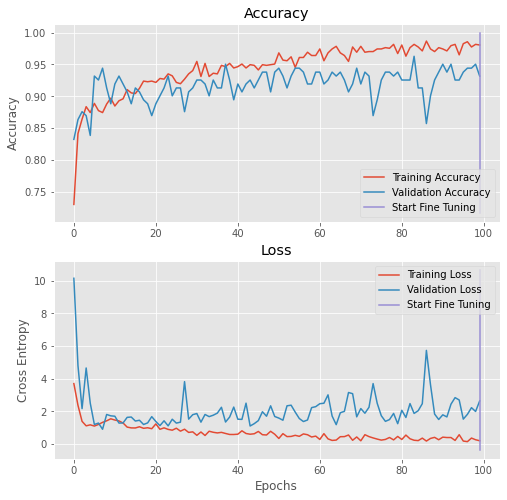

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/4 [======>.......................] - ETA: 0s - loss: 5.8773 - accuracy: 0.8359

2/4 [==============>...............] - ETA: 7s - loss: 4.1081 - accuracy: 0.8789

3/4 [=====================>........] - ETA: 4s - loss: 2.8182 - accuracy: 0.9141

4/4 [==============================] - ETA: 0s - loss: 2.4692 - accuracy: 0.9283

4/4 [==============================] - 26s 6s/step - loss: 2.4692 - accuracy: 0.9283


[2.469182252883911, 0.9282786846160889]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

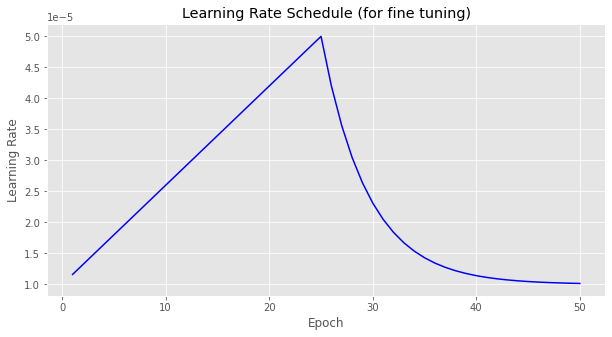

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 971 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1452 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 4s - loss: 0.0726 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 5s - loss: 0.1331 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 11s - loss: 0.2218 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 9s - loss: 0.1856 - accuracy: 0.9844 

 6/16 [==========>...................] - ETA: 10s - loss: 0.2884 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 9s - loss: 0.3148 - accuracy: 0.9777 

 8/16 [==============>...............] - ETA: 8s - loss: 0.2800 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 7s - loss: 0.3057 - accuracy: 0.9757

10/16 [=================>............] - ETA: 6s - loss: 0.3174 - accuracy: 0.9734

11/16 [===================>..........] - ETA: 5s - loss: 0.3007 - accuracy: 0.9744

12/16 [=====================>........] - ETA: 4s - loss: 0.3144 - accuracy: 0.9753

13/16 [=======================>......] - ETA: 3s - loss: 0.3173 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.2947 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 0s - loss: 0.3200 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.3706 - accuracy: 0.9753

16/16 [==============================] - 20s 1s/step - loss: 0.3706 - accuracy: 0.9753 - val_loss: 2.5580 - val_accuracy: 0.9317



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/16 [>.............................] - ETA: 0s - loss: 1.4472e-06 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.1699 - accuracy: 0.9766    

 3/16 [====>.........................] - ETA: 12s - loss: 0.1133 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 10s - loss: 0.2171 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 12s - loss: 0.2499 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 13s - loss: 0.2087 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 10s - loss: 0.2845 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 9s - loss: 0.2898 - accuracy: 0.9707 

 9/16 [===============>..............] - ETA: 9s - loss: 0.2933 - accuracy: 0.9705

10/16 [=================>............] - ETA: 8s - loss: 0.2640 - accuracy: 0.9734

11/16 [===================>..........] - ETA: 6s - loss: 0.2535 - accuracy: 0.9744

12/16 [=====================>........] - ETA: 4s - loss: 0.2798 - accuracy: 0.9727

13/16 [=======================>......] - ETA: 3s - loss: 0.2595 - accuracy: 0.9736

14/16 [=========================>....] - ETA: 2s - loss: 0.4156 - accuracy: 0.9710

15/16 [===========================>..] - ETA: 1s - loss: 0.3968 - accuracy: 0.9719

16/16 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.9722

16/16 [==============================] - 20s 1s/step - loss: 0.3924 - accuracy: 0.9722 - val_loss: 2.5149 - val_accuracy: 0.9317



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/16 [>.............................] - ETA: 0s - loss: 0.9163 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 12s - loss: 0.4615 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 12s - loss: 0.3077 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 17s - loss: 0.2601 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 13s - loss: 0.2644 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 13s - loss: 0.2204 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 13s - loss: 0.1953 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 12s - loss: 0.1709 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 11s - loss: 0.2232 - accuracy: 0.9861

10/16 [=================>............] - ETA: 8s - loss: 0.2009 - accuracy: 0.9875 

11/16 [===================>..........] - ETA: 7s - loss: 0.1833 - accuracy: 0.9886

12/16 [=====================>........] - ETA: 5s - loss: 0.1680 - accuracy: 0.9896

13/16 [=======================>......] - ETA: 3s - loss: 0.1701 - accuracy: 0.9892

14/16 [=========================>....] - ETA: 2s - loss: 0.1737 - accuracy: 0.9888

15/16 [===========================>..] - ETA: 1s - loss: 0.1621 - accuracy: 0.9896

16/16 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9887

16/16 [==============================] - 21s 1s/step - loss: 0.1617 - accuracy: 0.9887 - val_loss: 2.4894 - val_accuracy: 0.9317



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5678 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 7s - loss: 0.5270 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 13s - loss: 0.3651 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 14s - loss: 0.4150 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 12s - loss: 0.3326 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 13s - loss: 0.3560 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 13s - loss: 0.3052 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 12s - loss: 0.2801 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 10s - loss: 0.2490 - accuracy: 0.9844

10/16 [=================>............] - ETA: 8s - loss: 0.2879 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 6s - loss: 0.2685 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.2666 - accuracy: 0.9805

13/16 [=======================>......] - ETA: 3s - loss: 0.2556 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.2462 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.3041 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3286 - accuracy: 0.9773

16/16 [==============================] - 20s 1s/step - loss: 0.3286 - accuracy: 0.9773 - val_loss: 2.4927 - val_accuracy: 0.9379



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1080 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 10s - loss: 0.3058 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 18s - loss: 0.3377 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 15s - loss: 0.3731 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 13s - loss: 0.2985 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 15s - loss: 0.3548 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 14s - loss: 0.3257 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 12s - loss: 0.3090 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 11s - loss: 0.2760 - accuracy: 0.9809

10/16 [=================>............] - ETA: 8s - loss: 0.3368 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.3061 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.3030 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.2945 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.2807 - accuracy: 0.9810

15/16 [===========================>..] - ETA: 1s - loss: 0.2870 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.9794

16/16 [==============================] - 20s 1s/step - loss: 0.2837 - accuracy: 0.9794 - val_loss: 2.4913 - val_accuracy: 0.9379



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/16 [>.............................] - ETA: 0s - loss: 0.8021 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 12s - loss: 0.5383 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 13s - loss: 0.4641 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 13s - loss: 0.4619 - accuracy: 0.9648

 5/16 [========>.....................] - ETA: 15s - loss: 0.4245 - accuracy: 0.9688

 6/16 [==========>...................] - ETA: 14s - loss: 0.5750 - accuracy: 0.9609

 7/16 [============>.................] - ETA: 11s - loss: 0.4929 - accuracy: 0.9665

 8/16 [==============>...............] - ETA: 10s - loss: 0.4516 - accuracy: 0.9668

 9/16 [===============>..............] - ETA: 8s - loss: 0.4014 - accuracy: 0.9705 

10/16 [=================>............] - ETA: 7s - loss: 0.3891 - accuracy: 0.9719

11/16 [===================>..........] - ETA: 6s - loss: 0.3538 - accuracy: 0.9744

12/16 [=====================>........] - ETA: 4s - loss: 0.3243 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.2995 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2906 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.3048 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.9773

16/16 [==============================] - 20s 1s/step - loss: 0.3014 - accuracy: 0.9773 - val_loss: 2.4652 - val_accuracy: 0.9379



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/16 [>.............................] - ETA: 0s - loss: 0.8523 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 9s - loss: 0.7698 - accuracy: 0.9531

 3/16 [====>.........................] - ETA: 13s - loss: 0.5922 - accuracy: 0.9583

 4/16 [======>.......................] - ETA: 14s - loss: 0.6438 - accuracy: 0.9492

 5/16 [========>.....................] - ETA: 13s - loss: 0.5274 - accuracy: 0.9563

 6/16 [==========>...................] - ETA: 13s - loss: 0.4503 - accuracy: 0.9609

 7/16 [============>.................] - ETA: 13s - loss: 0.3860 - accuracy: 0.9665

 8/16 [==============>...............] - ETA: 12s - loss: 0.3383 - accuracy: 0.9707

 9/16 [===============>..............] - ETA: 10s - loss: 0.3348 - accuracy: 0.9722

10/16 [=================>............] - ETA: 8s - loss: 0.3033 - accuracy: 0.9734 

11/16 [===================>..........] - ETA: 6s - loss: 0.3215 - accuracy: 0.9730

12/16 [=====================>........] - ETA: 5s - loss: 0.3594 - accuracy: 0.9714

13/16 [=======================>......] - ETA: 3s - loss: 0.3598 - accuracy: 0.9724

14/16 [=========================>....] - ETA: 2s - loss: 0.3584 - accuracy: 0.9732

15/16 [===========================>..] - ETA: 1s - loss: 0.3753 - accuracy: 0.9729

16/16 [==============================] - ETA: 0s - loss: 0.4868 - accuracy: 0.9712

16/16 [==============================] - 20s 1s/step - loss: 0.4868 - accuracy: 0.9712 - val_loss: 2.4883 - val_accuracy: 0.9379



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.0010 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 17s - loss: 6.9137e-04 - accuracy: 1.0000

 4/16 [======>.......................] - ETA: 13s - loss: 0.1523 - accuracy: 0.9922    

 5/16 [========>.....................] - ETA: 18s - loss: 0.1219 - accuracy: 0.9937

 6/16 [==========>...................] - ETA: 15s - loss: 0.2435 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 14s - loss: 0.2383 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 13s - loss: 0.2085 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 11s - loss: 0.2409 - accuracy: 0.9826

10/16 [=================>............] - ETA: 9s - loss: 0.2168 - accuracy: 0.9844 

11/16 [===================>..........] - ETA: 7s - loss: 0.2764 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.2534 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.2407 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.2294 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.2188 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.9835

16/16 [==============================] - 21s 1s/step - loss: 0.2163 - accuracy: 0.9835 - val_loss: 2.4930 - val_accuracy: 0.9379



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2778 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 6s - loss: 0.2700 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 16s - loss: 0.1947 - accuracy: 0.9688

 4/16 [======>.......................] - ETA: 13s - loss: 0.2002 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 13s - loss: 0.1601 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 11s - loss: 0.1334 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 11s - loss: 0.1275 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 10s - loss: 0.1117 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 8s - loss: 0.0993 - accuracy: 0.9861 

10/16 [=================>............] - ETA: 7s - loss: 0.1209 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 6s - loss: 0.1103 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 5s - loss: 0.1278 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.1282 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.1501 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.1404 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9815

16/16 [==============================] - 20s 1s/step - loss: 0.1836 - accuracy: 0.9815 - val_loss: 2.5078 - val_accuracy: 0.9441



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/16 [>.............................] - ETA: 0s - loss: 0.4640 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 3s - loss: 0.2332 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 5s - loss: 0.1672 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 7s - loss: 0.2176 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 7s - loss: 0.1741 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 9s - loss: 0.1451 - accuracy: 0.9896

 7/16 [============>.................] - ETA: 8s - loss: 0.1244 - accuracy: 0.9911

 8/16 [==============>...............] - ETA: 9s - loss: 0.1101 - accuracy: 0.9922

 9/16 [===============>..............] - ETA: 8s - loss: 0.1304 - accuracy: 0.9913

10/16 [=================>............] - ETA: 7s - loss: 0.1373 - accuracy: 0.9906

11/16 [===================>..........] - ETA: 5s - loss: 0.1248 - accuracy: 0.9915

12/16 [=====================>........] - ETA: 4s - loss: 0.1210 - accuracy: 0.9909

13/16 [=======================>......] - ETA: 3s - loss: 0.1117 - accuracy: 0.9916

14/16 [=========================>....] - ETA: 2s - loss: 0.1037 - accuracy: 0.9922

15/16 [===========================>..] - ETA: 0s - loss: 0.1318 - accuracy: 0.9917

16/16 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9907

16/16 [==============================] - 18s 1s/step - loss: 0.1367 - accuracy: 0.9907 - val_loss: 2.5002 - val_accuracy: 0.9441



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/16 [>.............................] - ETA: 0s - loss: 1.8458e-06 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.0046 - accuracy: 1.0000    

 3/16 [====>.........................] - ETA: 12s - loss: 0.0407 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 13s - loss: 0.0591 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 10s - loss: 0.0516 - accuracy: 0.9875

 6/16 [==========>...................] - ETA: 12s - loss: 0.2545 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 11s - loss: 0.2353 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 11s - loss: 0.2459 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 10s - loss: 0.2683 - accuracy: 0.9774

10/16 [=================>............] - ETA: 8s - loss: 0.2515 - accuracy: 0.9781 

11/16 [===================>..........] - ETA: 6s - loss: 0.2445 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 4s - loss: 0.2569 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.2596 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2899 - accuracy: 0.9766

15/16 [===========================>..] - ETA: 1s - loss: 0.2729 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.9753

16/16 [==============================] - 19s 1s/step - loss: 0.3017 - accuracy: 0.9753 - val_loss: 2.5409 - val_accuracy: 0.9441



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0381 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 10s - loss: 0.0942 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 9s - loss: 0.1131 - accuracy: 0.9844 

 4/16 [======>.......................] - ETA: 9s - loss: 0.2321 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 16s - loss: 0.2230 - accuracy: 0.9688

 6/16 [==========>...................] - ETA: 15s - loss: 0.1873 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 14s - loss: 0.1892 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 11s - loss: 0.1802 - accuracy: 0.9727

 9/16 [===============>..............] - ETA: 10s - loss: 0.1602 - accuracy: 0.9757

10/16 [=================>............] - ETA: 8s - loss: 0.2546 - accuracy: 0.9703 

11/16 [===================>..........] - ETA: 6s - loss: 0.2315 - accuracy: 0.9730

12/16 [=====================>........] - ETA: 5s - loss: 0.2241 - accuracy: 0.9740

13/16 [=======================>......] - ETA: 3s - loss: 0.2488 - accuracy: 0.9736

14/16 [=========================>....] - ETA: 2s - loss: 0.2479 - accuracy: 0.9732

15/16 [===========================>..] - ETA: 1s - loss: 0.2314 - accuracy: 0.9750

16/16 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.9743

16/16 [==============================] - 20s 1s/step - loss: 0.2311 - accuracy: 0.9743 - val_loss: 2.5331 - val_accuracy: 0.9379



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2201 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 3s - loss: 0.3600 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 11s - loss: 0.4883 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 10s - loss: 0.3685 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 14s - loss: 0.3471 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 13s - loss: 0.3301 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 12s - loss: 0.2986 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 11s - loss: 0.3352 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 10s - loss: 0.3499 - accuracy: 0.9740

10/16 [=================>............] - ETA: 8s - loss: 0.3149 - accuracy: 0.9766 

11/16 [===================>..........] - ETA: 6s - loss: 0.3146 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 5s - loss: 0.4189 - accuracy: 0.9740

13/16 [=======================>......] - ETA: 3s - loss: 0.4152 - accuracy: 0.9736

14/16 [=========================>....] - ETA: 2s - loss: 0.3856 - accuracy: 0.9754

15/16 [===========================>..] - ETA: 1s - loss: 0.3949 - accuracy: 0.9760

16/16 [==============================] - ETA: 0s - loss: 0.3904 - accuracy: 0.9763

16/16 [==============================] - 20s 1s/step - loss: 0.3904 - accuracy: 0.9763 - val_loss: 2.5449 - val_accuracy: 0.9379



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1947 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 13s - loss: 0.4711 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 14s - loss: 0.3141 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 11s - loss: 0.3758 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 11s - loss: 0.3006 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 12s - loss: 0.3538 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 10s - loss: 0.3448 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 9s - loss: 0.3023 - accuracy: 0.9824 

 9/16 [===============>..............] - ETA: 8s - loss: 0.3321 - accuracy: 0.9809

10/16 [=================>............] - ETA: 6s - loss: 0.3676 - accuracy: 0.9750

11/16 [===================>..........] - ETA: 5s - loss: 0.3424 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 4s - loss: 0.3463 - accuracy: 0.9753

13/16 [=======================>......] - ETA: 3s - loss: 0.3197 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.2969 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.3133 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.3649 - accuracy: 0.9753

16/16 [==============================] - 19s 1s/step - loss: 0.3649 - accuracy: 0.9753 - val_loss: 2.5519 - val_accuracy: 0.9379



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7865 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 12s - loss: 0.6791 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 12s - loss: 0.4966 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 15s - loss: 0.5194 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 15s - loss: 0.4388 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 14s - loss: 0.3657 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 13s - loss: 0.3135 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 11s - loss: 0.2743 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 9s - loss: 0.2438 - accuracy: 0.9861 

10/16 [=================>............] - ETA: 7s - loss: 0.2510 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 6s - loss: 0.2426 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 4s - loss: 0.2224 - accuracy: 0.9857

13/16 [=======================>......] - ETA: 3s - loss: 0.2477 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.2682 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.2504 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.2476 - accuracy: 0.9846

16/16 [==============================] - 19s 1s/step - loss: 0.2476 - accuracy: 0.9846 - val_loss: 2.5439 - val_accuracy: 0.9379



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/16 [>.............................] - ETA: 0s - loss: 0.4948 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 3s - loss: 0.2474 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 17s - loss: 0.4793 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 14s - loss: 0.5317 - accuracy: 0.9609

 5/16 [========>.....................] - ETA: 11s - loss: 0.4525 - accuracy: 0.9625

 6/16 [==========>...................] - ETA: 10s - loss: 0.3771 - accuracy: 0.9688

 7/16 [============>.................] - ETA: 12s - loss: 0.3232 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 11s - loss: 0.2990 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 10s - loss: 0.2658 - accuracy: 0.9774

10/16 [=================>............] - ETA: 8s - loss: 0.2685 - accuracy: 0.9781 

11/16 [===================>..........] - ETA: 6s - loss: 0.2727 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 5s - loss: 0.2499 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.2307 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.2203 - accuracy: 0.9799

15/16 [===========================>..] - ETA: 1s - loss: 0.2490 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3259 - accuracy: 0.9763

16/16 [==============================] - 20s 1s/step - loss: 0.3259 - accuracy: 0.9763 - val_loss: 2.5340 - val_accuracy: 0.9379



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/16 [>.............................] - ETA: 0s - loss: 1.5959 - accuracy: 0.9219

 2/16 [==>...........................] - ETA: 3s - loss: 1.3917 - accuracy: 0.9453

 3/16 [====>.........................] - ETA: 8s - loss: 1.0642 - accuracy: 0.9531

 4/16 [======>.......................] - ETA: 11s - loss: 0.9459 - accuracy: 0.9570

 5/16 [========>.....................] - ETA: 15s - loss: 0.8971 - accuracy: 0.9563

 6/16 [==========>...................] - ETA: 13s - loss: 0.7744 - accuracy: 0.9609

 7/16 [============>.................] - ETA: 12s - loss: 0.6638 - accuracy: 0.9665

 8/16 [==============>...............] - ETA: 10s - loss: 0.5808 - accuracy: 0.9707

 9/16 [===============>..............] - ETA: 8s - loss: 0.5887 - accuracy: 0.9705 

10/16 [=================>............] - ETA: 7s - loss: 0.5372 - accuracy: 0.9719

11/16 [===================>..........] - ETA: 6s - loss: 0.4884 - accuracy: 0.9744

12/16 [=====================>........] - ETA: 4s - loss: 0.4831 - accuracy: 0.9740

13/16 [=======================>......] - ETA: 3s - loss: 0.4727 - accuracy: 0.9712

14/16 [=========================>....] - ETA: 2s - loss: 0.4947 - accuracy: 0.9699

15/16 [===========================>..] - ETA: 1s - loss: 0.4617 - accuracy: 0.9719

16/16 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.9712

16/16 [==============================] - 19s 1s/step - loss: 0.4581 - accuracy: 0.9712 - val_loss: 2.5567 - val_accuracy: 0.9379



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/16 [>.............................] - ETA: 0s - loss: 2.1270e-06 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 2.5084e-04 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 17s - loss: 1.7794e-04 - accuracy: 1.0000

 4/16 [======>.......................] - ETA: 13s - loss: 1.3345e-04 - accuracy: 1.0000

 5/16 [========>.....................] - ETA: 18s - loss: 0.2936 - accuracy: 0.9875    

 6/16 [==========>...................] - ETA: 17s - loss: 0.2496 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 15s - loss: 0.2140 - accuracy: 0.9888

 8/16 [==============>...............] - ETA: 13s - loss: 0.1873 - accuracy: 0.9902

 9/16 [===============>..............] - ETA: 11s - loss: 0.3003 - accuracy: 0.9861

10/16 [=================>............] - ETA: 8s - loss: 0.2702 - accuracy: 0.9875 

11/16 [===================>..........] - ETA: 7s - loss: 0.2781 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 5s - loss: 0.4331 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.4726 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.4739 - accuracy: 0.9766

15/16 [===========================>..] - ETA: 1s - loss: 0.4875 - accuracy: 0.9760

16/16 [==============================] - ETA: 0s - loss: 0.4820 - accuracy: 0.9763

16/16 [==============================] - 21s 1s/step - loss: 0.4820 - accuracy: 0.9763 - val_loss: 2.5980 - val_accuracy: 0.9379



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/16 [>.............................] - ETA: 0s - loss: 8.5015e-05 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.4302 - accuracy: 0.9766    

 3/16 [====>.........................] - ETA: 12s - loss: 0.2868 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 12s - loss: 0.2151 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 9s - loss: 0.2392 - accuracy: 0.9844 

 6/16 [==========>...................] - ETA: 10s - loss: 0.2593 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 10s - loss: 0.2226 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 10s - loss: 0.2440 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 8s - loss: 0.2169 - accuracy: 0.9826 

10/16 [=================>............] - ETA: 7s - loss: 0.1952 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 6s - loss: 0.2368 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 4s - loss: 0.2380 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.2396 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.2682 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.2651 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.9825

16/16 [==============================] - 19s 1s/step - loss: 0.2621 - accuracy: 0.9825 - val_loss: 2.6267 - val_accuracy: 0.9379



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1206 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 13s - loss: 0.2944 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 12s - loss: 0.4101 - accuracy: 0.9583

 4/16 [======>.......................] - ETA: 12s - loss: 0.3075 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 15s - loss: 0.2832 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 16s - loss: 0.2677 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 13s - loss: 0.2295 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 12s - loss: 0.2008 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 11s - loss: 0.1785 - accuracy: 0.9826

10/16 [=================>............] - ETA: 8s - loss: 0.1607 - accuracy: 0.9844 

11/16 [===================>..........] - ETA: 7s - loss: 0.1553 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 5s - loss: 0.1562 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.1700 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.1807 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.1691 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9835

16/16 [==============================] - 20s 1s/step - loss: 0.1852 - accuracy: 0.9835 - val_loss: 2.6497 - val_accuracy: 0.9379



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3099 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 3s - loss: 0.5308 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 10s - loss: 0.3551 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 14s - loss: 0.5617 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 17s - loss: 0.5609 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 16s - loss: 0.4674 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 14s - loss: 0.4087 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 12s - loss: 0.4916 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 10s - loss: 0.5256 - accuracy: 0.9809

10/16 [=================>............] - ETA: 8s - loss: 0.5088 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.4892 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.4625 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.4426 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.4112 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.4015 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.3970 - accuracy: 0.9835

16/16 [==============================] - 20s 1s/step - loss: 0.3970 - accuracy: 0.9835 - val_loss: 2.6568 - val_accuracy: 0.9379



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0401 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 3s - loss: 0.0239 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 11s - loss: 0.0444 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 9s - loss: 0.1676 - accuracy: 0.9844 

 5/16 [========>.....................] - ETA: 16s - loss: 0.1963 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 15s - loss: 0.1637 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 14s - loss: 0.1918 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.2828 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 10s - loss: 0.3153 - accuracy: 0.9792

10/16 [=================>............] - ETA: 8s - loss: 0.3322 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 6s - loss: 0.3030 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 4s - loss: 0.2778 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.2628 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.2440 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.2278 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.9846

16/16 [==============================] - 19s 1s/step - loss: 0.2268 - accuracy: 0.9846 - val_loss: 2.6776 - val_accuracy: 0.9379



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/16 [>.............................] - ETA: 0s - loss: 2.0652e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.0987 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 14s - loss: 0.1182 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 11s - loss: 0.1857 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 16s - loss: 0.2509 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 15s - loss: 0.2261 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 12s - loss: 0.1955 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 11s - loss: 0.2468 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 10s - loss: 0.2194 - accuracy: 0.9826

10/16 [=================>............] - ETA: 8s - loss: 0.2950 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 6s - loss: 0.2681 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 5s - loss: 0.2458 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.2269 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.2107 - accuracy: 0.9866

15/16 [===========================>..] - ETA: 1s - loss: 0.1966 - accuracy: 0.9875

16/16 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9876

16/16 [==============================] - 20s 1s/step - loss: 0.1944 - accuracy: 0.9876 - val_loss: 2.6807 - val_accuracy: 0.9379



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/16 [>.............................] - ETA: 0s - loss: 0.5322 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 10s - loss: 0.5282 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 14s - loss: 0.5563 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 13s - loss: 0.4180 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 13s - loss: 0.4872 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 14s - loss: 0.4656 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 13s - loss: 0.3991 - accuracy: 0.9799

 8/16 [==============>...............] - ETA: 12s - loss: 0.3596 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 11s - loss: 0.3196 - accuracy: 0.9826

10/16 [=================>............] - ETA: 8s - loss: 0.2877 - accuracy: 0.9844 

11/16 [===================>..........] - ETA: 7s - loss: 0.2618 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 5s - loss: 0.3005 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.3562 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.3308 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.3088 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.9846

16/16 [==============================] - 20s 1s/step - loss: 0.3053 - accuracy: 0.9846 - val_loss: 2.6951 - val_accuracy: 0.9379



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/16 [>.............................] - ETA: 0s - loss: 5.2117e-05 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 9s - loss: 0.0031 - accuracy: 1.0000    

 3/16 [====>.........................] - ETA: 11s - loss: 0.0021 - accuracy: 1.0000

 4/16 [======>.......................] - ETA: 12s - loss: 0.0407 - accuracy: 0.9961

 5/16 [========>.....................] - ETA: 10s - loss: 0.2312 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 11s - loss: 0.3763 - accuracy: 0.9896

 7/16 [============>.................] - ETA: 9s - loss: 0.3265 - accuracy: 0.9888 

 8/16 [==============>...............] - ETA: 9s - loss: 0.3202 - accuracy: 0.9883

 9/16 [===============>..............] - ETA: 7s - loss: 0.3393 - accuracy: 0.9844

10/16 [=================>............] - ETA: 6s - loss: 0.3261 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 5s - loss: 0.2966 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 4s - loss: 0.2719 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.2565 - accuracy: 0.9868

14/16 [=========================>....] - ETA: 2s - loss: 0.2382 - accuracy: 0.9877

15/16 [===========================>..] - ETA: 0s - loss: 0.2258 - accuracy: 0.9875

16/16 [==============================] - ETA: 0s - loss: 0.2308 - accuracy: 0.9866

16/16 [==============================] - 18s 1s/step - loss: 0.2308 - accuracy: 0.9866 - val_loss: 2.7191 - val_accuracy: 0.9379



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7205 - accuracy: 0.9531

 2/16 [==>...........................] - ETA: 5s - loss: 0.5699 - accuracy: 0.9688

 3/16 [====>.........................] - ETA: 6s - loss: 0.3799 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 7s - loss: 0.3043 - accuracy: 0.9766

 5/16 [========>.....................] - ETA: 11s - loss: 0.3062 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 11s - loss: 0.2555 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 9s - loss: 0.2933 - accuracy: 0.9777 

 8/16 [==============>...............] - ETA: 8s - loss: 0.3044 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 8s - loss: 0.3079 - accuracy: 0.9740

10/16 [=================>............] - ETA: 7s - loss: 0.3347 - accuracy: 0.9703

11/16 [===================>..........] - ETA: 6s - loss: 0.3046 - accuracy: 0.9730

12/16 [=====================>........] - ETA: 4s - loss: 0.2906 - accuracy: 0.9740

13/16 [=======================>......] - ETA: 3s - loss: 0.2682 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.2738 - accuracy: 0.9766

15/16 [===========================>..] - ETA: 1s - loss: 0.3351 - accuracy: 0.9750

16/16 [==============================] - ETA: 0s - loss: 0.3313 - accuracy: 0.9753

16/16 [==============================] - 18s 1s/step - loss: 0.3313 - accuracy: 0.9753 - val_loss: 2.7200 - val_accuracy: 0.9379



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 12s - loss: 0.0011 - accuracy: 1.0000   

 3/16 [====>.........................] - ETA: 12s - loss: 7.7670e-04 - accuracy: 1.0000

 4/16 [======>.......................] - ETA: 12s - loss: 5.8252e-04 - accuracy: 1.0000

 5/16 [========>.....................] - ETA: 14s - loss: 0.2045 - accuracy: 0.9906    

 6/16 [==========>...................] - ETA: 13s - loss: 0.1777 - accuracy: 0.9896

 7/16 [============>.................] - ETA: 13s - loss: 0.1523 - accuracy: 0.9911

 8/16 [==============>...............] - ETA: 12s - loss: 0.1333 - accuracy: 0.9922

 9/16 [===============>..............] - ETA: 11s - loss: 0.1185 - accuracy: 0.9931

10/16 [=================>............] - ETA: 8s - loss: 0.1323 - accuracy: 0.9922 

11/16 [===================>..........] - ETA: 7s - loss: 0.1331 - accuracy: 0.9915

12/16 [=====================>........] - ETA: 5s - loss: 0.1346 - accuracy: 0.9909

13/16 [=======================>......] - ETA: 3s - loss: 0.1336 - accuracy: 0.9904

14/16 [=========================>....] - ETA: 2s - loss: 0.1241 - accuracy: 0.9911

15/16 [===========================>..] - ETA: 1s - loss: 0.1199 - accuracy: 0.9906

16/16 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9907

16/16 [==============================] - 20s 1s/step - loss: 0.1186 - accuracy: 0.9907 - val_loss: 2.7230 - val_accuracy: 0.9379



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/16 [>.............................] - ETA: 0s - loss: 5.0793e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.0081 - accuracy: 0.9922    

 3/16 [====>.........................] - ETA: 10s - loss: 0.0826 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 12s - loss: 0.1451 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 11s - loss: 0.1777 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 12s - loss: 0.2201 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 10s - loss: 0.2018 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 9s - loss: 0.2030 - accuracy: 0.9766 

 9/16 [===============>..............] - ETA: 8s - loss: 0.1847 - accuracy: 0.9774

10/16 [=================>............] - ETA: 6s - loss: 0.1686 - accuracy: 0.9781

11/16 [===================>..........] - ETA: 5s - loss: 0.1943 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 4s - loss: 0.1802 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.2805 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.2949 - accuracy: 0.9754

15/16 [===========================>..] - ETA: 1s - loss: 0.2914 - accuracy: 0.9760

16/16 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.9763

16/16 [==============================] - 19s 1s/step - loss: 0.2881 - accuracy: 0.9763 - val_loss: 2.7274 - val_accuracy: 0.9379



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/16 [>.............................] - ETA: 0s - loss: 0.4250 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 3s - loss: 0.2276 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 4s - loss: 0.2191 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 4s - loss: 0.2374 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 7s - loss: 0.3345 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 9s - loss: 0.2834 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 9s - loss: 0.3118 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 9s - loss: 0.2728 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 8s - loss: 0.2429 - accuracy: 0.9826

10/16 [=================>............] - ETA: 7s - loss: 0.2194 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 5s - loss: 0.2008 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 4s - loss: 0.1841 - accuracy: 0.9857

13/16 [=======================>......] - ETA: 3s - loss: 0.1882 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.1748 - accuracy: 0.9866

15/16 [===========================>..] - ETA: 0s - loss: 0.1671 - accuracy: 0.9865

16/16 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.9866

16/16 [==============================] - 18s 1s/step - loss: 0.1652 - accuracy: 0.9866 - val_loss: 2.7280 - val_accuracy: 0.9379



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0510 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 7s - loss: 0.1563 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 16s - loss: 0.1071 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 13s - loss: 0.0803 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 12s - loss: 0.0734 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 11s - loss: 0.0912 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 13s - loss: 0.1162 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 11s - loss: 0.1618 - accuracy: 0.9863

 9/16 [===============>..............] - ETA: 10s - loss: 0.1894 - accuracy: 0.9844

10/16 [=================>............] - ETA: 8s - loss: 0.1705 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 6s - loss: 0.1550 - accuracy: 0.9872

12/16 [=====================>........] - ETA: 5s - loss: 0.1814 - accuracy: 0.9857

13/16 [=======================>......] - ETA: 3s - loss: 0.1674 - accuracy: 0.9868

14/16 [=========================>....] - ETA: 2s - loss: 0.2132 - accuracy: 0.9844

15/16 [===========================>..] - ETA: 1s - loss: 0.2048 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.9835

16/16 [==============================] - 20s 1s/step - loss: 0.2025 - accuracy: 0.9835 - val_loss: 2.7177 - val_accuracy: 0.9379



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1510 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 12s - loss: 0.1259 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 12s - loss: 0.2811 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 13s - loss: 0.2722 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 14s - loss: 0.2213 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 11s - loss: 0.1849 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 10s - loss: 0.2358 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 8s - loss: 0.2635 - accuracy: 0.9746 

 9/16 [===============>..............] - ETA: 7s - loss: 0.2347 - accuracy: 0.9774

10/16 [=================>............] - ETA: 6s - loss: 0.2153 - accuracy: 0.9781

11/16 [===================>..........] - ETA: 5s - loss: 0.2486 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 4s - loss: 0.2282 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.2118 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 1s - loss: 0.1967 - accuracy: 0.9810

15/16 [===========================>..] - ETA: 0s - loss: 0.3400 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.9784

16/16 [==============================] - 17s 1s/step - loss: 0.3636 - accuracy: 0.9784 - val_loss: 2.7106 - val_accuracy: 0.9379



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7869 - accuracy: 0.9375

 2/16 [==>...........................] - ETA: 15s - loss: 0.4284 - accuracy: 0.9531

 3/16 [====>.........................] - ETA: 14s - loss: 0.3537 - accuracy: 0.9583

 4/16 [======>.......................] - ETA: 13s - loss: 0.2653 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 19s - loss: 0.2973 - accuracy: 0.9688

 6/16 [==========>...................] - ETA: 17s - loss: 0.2654 - accuracy: 0.9688

 7/16 [============>.................] - ETA: 15s - loss: 0.2275 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 12s - loss: 0.2622 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 10s - loss: 0.2593 - accuracy: 0.9757

10/16 [=================>............] - ETA: 8s - loss: 0.2487 - accuracy: 0.9766 

11/16 [===================>..........] - ETA: 7s - loss: 0.2261 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 5s - loss: 0.2095 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.1968 - accuracy: 0.9796

14/16 [=========================>....] - ETA: 2s - loss: 0.1827 - accuracy: 0.9810

15/16 [===========================>..] - ETA: 1s - loss: 0.1706 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9825

16/16 [==============================] - 21s 1s/step - loss: 0.1686 - accuracy: 0.9825 - val_loss: 2.7118 - val_accuracy: 0.9379



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 7s - loss: 0.1233 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 13s - loss: 0.0822 - accuracy: 0.9948

 4/16 [======>.......................] - ETA: 15s - loss: 0.0956 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 18s - loss: 0.1789 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 17s - loss: 0.2062 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 15s - loss: 0.1829 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 12s - loss: 0.1999 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 10s - loss: 0.1777 - accuracy: 0.9861

10/16 [=================>............] - ETA: 8s - loss: 0.1763 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 6s - loss: 0.1779 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 5s - loss: 0.2170 - accuracy: 0.9857

13/16 [=======================>......] - ETA: 3s - loss: 0.2108 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.1958 - accuracy: 0.9866

15/16 [===========================>..] - ETA: 1s - loss: 0.1887 - accuracy: 0.9865

16/16 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9866

16/16 [==============================] - 20s 1s/step - loss: 0.1866 - accuracy: 0.9866 - val_loss: 2.6919 - val_accuracy: 0.9379



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 8s - loss: 1.3411e-07 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 17s - loss: 2.5124e-06 - accuracy: 1.0000

 4/16 [======>.......................] - ETA: 17s - loss: 2.0650e-06 - accuracy: 1.0000

 5/16 [========>.....................] - ETA: 18s - loss: 0.0294 - accuracy: 0.9969    

 6/16 [==========>...................] - ETA: 16s - loss: 0.0579 - accuracy: 0.9948

 7/16 [============>.................] - ETA: 15s - loss: 0.0497 - accuracy: 0.9955

 8/16 [==============>...............] - ETA: 12s - loss: 0.0435 - accuracy: 0.9961

 9/16 [===============>..............] - ETA: 10s - loss: 0.0386 - accuracy: 0.9965

10/16 [=================>............] - ETA: 8s - loss: 0.0348 - accuracy: 0.9969 

11/16 [===================>..........] - ETA: 6s - loss: 0.0757 - accuracy: 0.9957

12/16 [=====================>........] - ETA: 5s - loss: 0.0694 - accuracy: 0.9961

13/16 [=======================>......] - ETA: 3s - loss: 0.0763 - accuracy: 0.9952

14/16 [=========================>....] - ETA: 2s - loss: 0.0747 - accuracy: 0.9944

15/16 [===========================>..] - ETA: 1s - loss: 0.1174 - accuracy: 0.9927

16/16 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.9928

16/16 [==============================] - 20s 1s/step - loss: 0.1160 - accuracy: 0.9928 - val_loss: 2.6940 - val_accuracy: 0.9379



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1893 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 12s - loss: 0.2931 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 15s - loss: 0.2637 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 11s - loss: 0.4065 - accuracy: 0.9570

 5/16 [========>.....................] - ETA: 18s - loss: 0.5004 - accuracy: 0.9625

 6/16 [==========>...................] - ETA: 16s - loss: 0.4912 - accuracy: 0.9661

 7/16 [============>.................] - ETA: 16s - loss: 0.5351 - accuracy: 0.9643

 8/16 [==============>...............] - ETA: 12s - loss: 0.4765 - accuracy: 0.9668

 9/16 [===============>..............] - ETA: 11s - loss: 0.4236 - accuracy: 0.9705

10/16 [=================>............] - ETA: 9s - loss: 0.3812 - accuracy: 0.9734 

11/16 [===================>..........] - ETA: 7s - loss: 0.3466 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 5s - loss: 0.3192 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.3581 - accuracy: 0.9760

14/16 [=========================>....] - ETA: 2s - loss: 0.3438 - accuracy: 0.9766

15/16 [===========================>..] - ETA: 1s - loss: 0.3209 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3388 - accuracy: 0.9763

16/16 [==============================] - 21s 1s/step - loss: 0.3388 - accuracy: 0.9763 - val_loss: 2.7176 - val_accuracy: 0.9379



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0948 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 7s - loss: 0.0584 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 15s - loss: 0.1862 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 15s - loss: 0.2167 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 15s - loss: 0.2520 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 13s - loss: 0.2537 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 11s - loss: 0.2175 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 10s - loss: 0.2129 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 8s - loss: 0.2069 - accuracy: 0.9826 

10/16 [=================>............] - ETA: 7s - loss: 0.1974 - accuracy: 0.9812

11/16 [===================>..........] - ETA: 5s - loss: 0.1794 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 4s - loss: 0.1645 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.1807 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.1956 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2064 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.2363 - accuracy: 0.9804

16/16 [==============================] - 19s 1s/step - loss: 0.2363 - accuracy: 0.9804 - val_loss: 2.6900 - val_accuracy: 0.9379



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1041 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 6s - loss: 0.2036 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 17s - loss: 0.4177 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 13s - loss: 0.3133 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 18s - loss: 0.2587 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 16s - loss: 0.2433 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 15s - loss: 0.3242 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 12s - loss: 0.3086 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 10s - loss: 0.2876 - accuracy: 0.9757

10/16 [=================>............] - ETA: 8s - loss: 0.2693 - accuracy: 0.9766 

11/16 [===================>..........] - ETA: 6s - loss: 0.2448 - accuracy: 0.9787

12/16 [=====================>........] - ETA: 5s - loss: 0.2904 - accuracy: 0.9779

13/16 [=======================>......] - ETA: 3s - loss: 0.2759 - accuracy: 0.9784

14/16 [=========================>....] - ETA: 2s - loss: 0.2599 - accuracy: 0.9788

15/16 [===========================>..] - ETA: 1s - loss: 0.2438 - accuracy: 0.9792

16/16 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.9794

16/16 [==============================] - 20s 1s/step - loss: 0.2411 - accuracy: 0.9794 - val_loss: 2.6769 - val_accuracy: 0.9379



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1661 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 12s - loss: 0.4556 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 12s - loss: 0.4773 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 10s - loss: 0.3580 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 9s - loss: 0.4137 - accuracy: 0.9781 

 6/16 [==========>...................] - ETA: 8s - loss: 0.3993 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 9s - loss: 0.3469 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 10s - loss: 0.3314 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 8s - loss: 0.3103 - accuracy: 0.9774 

10/16 [=================>............] - ETA: 7s - loss: 0.2793 - accuracy: 0.9797

11/16 [===================>..........] - ETA: 5s - loss: 0.4165 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 4s - loss: 0.3858 - accuracy: 0.9766

13/16 [=======================>......] - ETA: 3s - loss: 0.3640 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.3810 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 0s - loss: 0.3609 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3569 - accuracy: 0.9784

16/16 [==============================] - 18s 1s/step - loss: 0.3569 - accuracy: 0.9784 - val_loss: 2.6791 - val_accuracy: 0.9379



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/16 [>.............................] - ETA: 0s - loss: 6.7925e-04 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 3.4440e-04 - accuracy: 1.0000

 3/16 [====>.........................] - ETA: 12s - loss: 0.1729 - accuracy: 0.9896   

 4/16 [======>.......................] - ETA: 10s - loss: 0.2413 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 15s - loss: 0.3046 - accuracy: 0.9812

 6/16 [==========>...................] - ETA: 14s - loss: 0.2590 - accuracy: 0.9818

 7/16 [============>.................] - ETA: 12s - loss: 0.2492 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 11s - loss: 0.2230 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 9s - loss: 0.1982 - accuracy: 0.9844 

10/16 [=================>............] - ETA: 8s - loss: 0.1875 - accuracy: 0.9844

11/16 [===================>..........] - ETA: 6s - loss: 0.1704 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 4s - loss: 0.1860 - accuracy: 0.9844

13/16 [=======================>......] - ETA: 3s - loss: 0.2002 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.1859 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.1886 - accuracy: 0.9823

16/16 [==============================] - ETA: 0s - loss: 0.1865 - accuracy: 0.9825

16/16 [==============================] - 19s 1s/step - loss: 0.1865 - accuracy: 0.9825 - val_loss: 2.6936 - val_accuracy: 0.9379



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/16 [>.............................] - ETA: 0s - loss: 0.7206 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 4s - loss: 0.3603 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 16s - loss: 0.4788 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 12s - loss: 0.5235 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 12s - loss: 0.4418 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 13s - loss: 0.4731 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 11s - loss: 0.4294 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 10s - loss: 0.4508 - accuracy: 0.9707

 9/16 [===============>..............] - ETA: 8s - loss: 0.4058 - accuracy: 0.9722 

10/16 [=================>............] - ETA: 7s - loss: 0.4031 - accuracy: 0.9734

11/16 [===================>..........] - ETA: 6s - loss: 0.3665 - accuracy: 0.9759

12/16 [=====================>........] - ETA: 5s - loss: 0.3824 - accuracy: 0.9753

13/16 [=======================>......] - ETA: 3s - loss: 0.3530 - accuracy: 0.9772

14/16 [=========================>....] - ETA: 2s - loss: 0.3517 - accuracy: 0.9777

15/16 [===========================>..] - ETA: 1s - loss: 0.3365 - accuracy: 0.9771

16/16 [==============================] - ETA: 0s - loss: 0.3327 - accuracy: 0.9773

16/16 [==============================] - 20s 1s/step - loss: 0.3327 - accuracy: 0.9773 - val_loss: 2.6820 - val_accuracy: 0.9379



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/16 [>.............................] - ETA: 0s - loss: 0.3689 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 9s - loss: 0.1981 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 8s - loss: 0.2141 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 10s - loss: 0.2025 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 8s - loss: 0.3226 - accuracy: 0.9781 

 6/16 [==========>...................] - ETA: 8s - loss: 0.2748 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 7s - loss: 0.2968 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 7s - loss: 0.2800 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 7s - loss: 0.2492 - accuracy: 0.9809

10/16 [=================>............] - ETA: 6s - loss: 0.2243 - accuracy: 0.9828

11/16 [===================>..........] - ETA: 5s - loss: 0.2050 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 4s - loss: 0.2190 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 2s - loss: 0.2124 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 1s - loss: 0.2279 - accuracy: 0.9810

15/16 [===========================>..] - ETA: 0s - loss: 0.2365 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.9804

16/16 [==============================] - 17s 1s/step - loss: 0.2338 - accuracy: 0.9804 - val_loss: 2.6801 - val_accuracy: 0.9379



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1623 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 3s - loss: 0.4877 - accuracy: 0.9531

 3/16 [====>.........................] - ETA: 17s - loss: 0.4857 - accuracy: 0.9635

 4/16 [======>.......................] - ETA: 17s - loss: 0.4045 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 13s - loss: 0.3865 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 13s - loss: 0.3592 - accuracy: 0.9740

 7/16 [============>.................] - ETA: 13s - loss: 0.3114 - accuracy: 0.9754

 8/16 [==============>...............] - ETA: 11s - loss: 0.3183 - accuracy: 0.9766

 9/16 [===============>..............] - ETA: 10s - loss: 0.3874 - accuracy: 0.9722

10/16 [=================>............] - ETA: 8s - loss: 0.3618 - accuracy: 0.9734 

11/16 [===================>..........] - ETA: 6s - loss: 0.3908 - accuracy: 0.9730

12/16 [=====================>........] - ETA: 5s - loss: 0.4061 - accuracy: 0.9740

13/16 [=======================>......] - ETA: 3s - loss: 0.3859 - accuracy: 0.9748

14/16 [=========================>....] - ETA: 2s - loss: 0.3583 - accuracy: 0.9766

15/16 [===========================>..] - ETA: 1s - loss: 0.3344 - accuracy: 0.9781

16/16 [==============================] - ETA: 0s - loss: 0.3306 - accuracy: 0.9784

16/16 [==============================] - 20s 1s/step - loss: 0.3306 - accuracy: 0.9784 - val_loss: 2.6563 - val_accuracy: 0.9379



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/16 [>.............................] - ETA: 0s - loss: 0.0762 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 10s - loss: 0.2610 - accuracy: 0.9609

 3/16 [====>.........................] - ETA: 8s - loss: 0.1741 - accuracy: 0.9740 

 4/16 [======>.......................] - ETA: 8s - loss: 0.3230 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 10s - loss: 0.2713 - accuracy: 0.9719

 6/16 [==========>...................] - ETA: 12s - loss: 0.2261 - accuracy: 0.9766

 7/16 [============>.................] - ETA: 11s - loss: 0.2685 - accuracy: 0.9777

 8/16 [==============>...............] - ETA: 11s - loss: 0.2832 - accuracy: 0.9785

 9/16 [===============>..............] - ETA: 10s - loss: 0.3135 - accuracy: 0.9774

10/16 [=================>............] - ETA: 8s - loss: 0.2821 - accuracy: 0.9797 

11/16 [===================>..........] - ETA: 6s - loss: 0.2618 - accuracy: 0.9801

12/16 [=====================>........] - ETA: 5s - loss: 0.2400 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.2476 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.2300 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2508 - accuracy: 0.9802

16/16 [==============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.9804

16/16 [==============================] - 20s 1s/step - loss: 0.2480 - accuracy: 0.9804 - val_loss: 2.6318 - val_accuracy: 0.9379



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/16 [>.............................] - ETA: 0s - loss: 2.0489e-08 - accuracy: 1.0000

 2/16 [==>...........................] - ETA: 3s - loss: 0.2643 - accuracy: 0.9766    

 3/16 [====>.........................] - ETA: 20s - loss: 0.3240 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 15s - loss: 0.3814 - accuracy: 0.9688

 5/16 [========>.....................] - ETA: 12s - loss: 0.3668 - accuracy: 0.9688

 6/16 [==========>...................] - ETA: 13s - loss: 0.3100 - accuracy: 0.9714

 7/16 [============>.................] - ETA: 12s - loss: 0.3456 - accuracy: 0.9732

 8/16 [==============>...............] - ETA: 11s - loss: 0.3054 - accuracy: 0.9746

 9/16 [===============>..............] - ETA: 10s - loss: 0.3280 - accuracy: 0.9740

10/16 [=================>............] - ETA: 8s - loss: 0.2955 - accuracy: 0.9766 

11/16 [===================>..........] - ETA: 6s - loss: 0.2728 - accuracy: 0.9773

12/16 [=====================>........] - ETA: 5s - loss: 0.2501 - accuracy: 0.9792

13/16 [=======================>......] - ETA: 3s - loss: 0.2309 - accuracy: 0.9808

14/16 [=========================>....] - ETA: 2s - loss: 0.2144 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2002 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9835

16/16 [==============================] - 20s 1s/step - loss: 0.1979 - accuracy: 0.9835 - val_loss: 2.7612 - val_accuracy: 0.9379



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1114 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 7s - loss: 0.0557 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 12s - loss: 0.0637 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 12s - loss: 0.0931 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 12s - loss: 0.0745 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 13s - loss: 0.1479 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 13s - loss: 0.1268 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 11s - loss: 0.1190 - accuracy: 0.9844

 9/16 [===============>..............] - ETA: 10s - loss: 0.1060 - accuracy: 0.9861

10/16 [=================>............] - ETA: 8s - loss: 0.1051 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 6s - loss: 0.0955 - accuracy: 0.9872

12/16 [=====================>........] - ETA: 5s - loss: 0.1605 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.1973 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.2152 - accuracy: 0.9821

15/16 [===========================>..] - ETA: 1s - loss: 0.2041 - accuracy: 0.9812

16/16 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.9815

16/16 [==============================] - 20s 1s/step - loss: 0.2018 - accuracy: 0.9815 - val_loss: 2.8118 - val_accuracy: 0.9379



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1087 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 3s - loss: 0.0544 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 17s - loss: 0.3221 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 14s - loss: 0.4138 - accuracy: 0.9805

 5/16 [========>.....................] - ETA: 13s - loss: 0.3311 - accuracy: 0.9844

 6/16 [==========>...................] - ETA: 12s - loss: 0.4145 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 10s - loss: 0.4006 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 9s - loss: 0.3591 - accuracy: 0.9844 

 9/16 [===============>..............] - ETA: 7s - loss: 0.3315 - accuracy: 0.9844

10/16 [=================>............] - ETA: 6s - loss: 0.2999 - accuracy: 0.9859

11/16 [===================>..........] - ETA: 6s - loss: 0.2879 - accuracy: 0.9858

12/16 [=====================>........] - ETA: 4s - loss: 0.2639 - accuracy: 0.9870

13/16 [=======================>......] - ETA: 3s - loss: 0.2638 - accuracy: 0.9856

14/16 [=========================>....] - ETA: 2s - loss: 0.2740 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.2718 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.9846

16/16 [==============================] - 19s 1s/step - loss: 0.2875 - accuracy: 0.9846 - val_loss: 2.7921 - val_accuracy: 0.9379



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/16 [>.............................] - ETA: 0s - loss: 0.2996 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 5s - loss: 0.2718 - accuracy: 0.9844

 3/16 [====>.........................] - ETA: 5s - loss: 0.7108 - accuracy: 0.9792

 4/16 [======>.......................] - ETA: 8s - loss: 0.5340 - accuracy: 0.9844

 5/16 [========>.....................] - ETA: 14s - loss: 0.5752 - accuracy: 0.9781

 6/16 [==========>...................] - ETA: 13s - loss: 0.4825 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 13s - loss: 0.4136 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 10s - loss: 0.4058 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 9s - loss: 0.3607 - accuracy: 0.9844 

10/16 [=================>............] - ETA: 7s - loss: 0.3305 - accuracy: 0.9828

11/16 [===================>..........] - ETA: 6s - loss: 0.3086 - accuracy: 0.9830

12/16 [=====================>........] - ETA: 4s - loss: 0.3280 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.3028 - accuracy: 0.9832

14/16 [=========================>....] - ETA: 2s - loss: 0.2896 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.2858 - accuracy: 0.9833

16/16 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.9825

16/16 [==============================] - 18s 1s/step - loss: 0.2895 - accuracy: 0.9825 - val_loss: 2.7411 - val_accuracy: 0.9379



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/16 [>.............................] - ETA: 0s - loss: 0.6105 - accuracy: 0.9688

 2/16 [==>...........................] - ETA: 8s - loss: 0.3371 - accuracy: 0.9766

 3/16 [====>.........................] - ETA: 22s - loss: 0.4842 - accuracy: 0.9740

 4/16 [======>.......................] - ETA: 26s - loss: 0.4877 - accuracy: 0.9727

 5/16 [========>.....................] - ETA: 24s - loss: 0.4398 - accuracy: 0.9750

 6/16 [==========>...................] - ETA: 20s - loss: 0.3665 - accuracy: 0.9792

 7/16 [============>.................] - ETA: 16s - loss: 0.3144 - accuracy: 0.9821

 8/16 [==============>...............] - ETA: 13s - loss: 0.3135 - accuracy: 0.9824

 9/16 [===============>..............] - ETA: 11s - loss: 0.2787 - accuracy: 0.9844

10/16 [=================>............] - ETA: 9s - loss: 0.2508 - accuracy: 0.9859 

11/16 [===================>..........] - ETA: 7s - loss: 0.2649 - accuracy: 0.9844

12/16 [=====================>........] - ETA: 5s - loss: 0.2458 - accuracy: 0.9831

13/16 [=======================>......] - ETA: 3s - loss: 0.2269 - accuracy: 0.9844

14/16 [=========================>....] - ETA: 2s - loss: 0.2107 - accuracy: 0.9855

15/16 [===========================>..] - ETA: 1s - loss: 0.2098 - accuracy: 0.9854

16/16 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.9846

16/16 [==============================] - 21s 1s/step - loss: 0.2444 - accuracy: 0.9846 - val_loss: 2.7594 - val_accuracy: 0.9379



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/16 [>.............................] - ETA: 0s - loss: 0.1507 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 12s - loss: 0.0760 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 15s - loss: 0.1099 - accuracy: 0.9844

 4/16 [======>.......................] - ETA: 16s - loss: 0.0824 - accuracy: 0.9883

 5/16 [========>.....................] - ETA: 15s - loss: 0.0659 - accuracy: 0.9906

 6/16 [==========>...................] - ETA: 15s - loss: 0.1570 - accuracy: 0.9844

 7/16 [============>.................] - ETA: 14s - loss: 0.1609 - accuracy: 0.9844

 8/16 [==============>...............] - ETA: 12s - loss: 0.2497 - accuracy: 0.9805

 9/16 [===============>..............] - ETA: 11s - loss: 0.2313 - accuracy: 0.9809

10/16 [=================>............] - ETA: 9s - loss: 0.2307 - accuracy: 0.9812 

11/16 [===================>..........] - ETA: 7s - loss: 0.2231 - accuracy: 0.9815

12/16 [=====================>........] - ETA: 5s - loss: 0.2090 - accuracy: 0.9818

13/16 [=======================>......] - ETA: 3s - loss: 0.2282 - accuracy: 0.9820

14/16 [=========================>....] - ETA: 2s - loss: 0.2119 - accuracy: 0.9833

15/16 [===========================>..] - ETA: 1s - loss: 0.1977 - accuracy: 0.9844

16/16 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9835

16/16 [==============================] - 21s 1s/step - loss: 0.2107 - accuracy: 0.9835 - val_loss: 2.7641 - val_accuracy: 0.9379



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/16 [>.............................] - ETA: 0s - loss: 0.6145 - accuracy: 0.9844

 2/16 [==>...........................] - ETA: 7s - loss: 0.3087 - accuracy: 0.9922

 3/16 [====>.........................] - ETA: 10s - loss: 0.3678 - accuracy: 0.9896

 4/16 [======>.......................] - ETA: 10s - loss: 0.2758 - accuracy: 0.9922

 5/16 [========>.....................] - ETA: 17s - loss: 0.2207 - accuracy: 0.9937

 6/16 [==========>...................] - ETA: 16s - loss: 0.2763 - accuracy: 0.9870

 7/16 [============>.................] - ETA: 15s - loss: 0.2750 - accuracy: 0.9866

 8/16 [==============>...............] - ETA: 12s - loss: 0.2407 - accuracy: 0.9883

 9/16 [===============>..............] - ETA: 10s - loss: 0.2398 - accuracy: 0.9878

10/16 [=================>............] - ETA: 8s - loss: 0.2280 - accuracy: 0.9875 

11/16 [===================>..........] - ETA: 6s - loss: 0.2073 - accuracy: 0.9886

12/16 [=====================>........] - ETA: 5s - loss: 0.1900 - accuracy: 0.9896

13/16 [=======================>......] - ETA: 3s - loss: 0.1754 - accuracy: 0.9904

14/16 [=========================>....] - ETA: 2s - loss: 0.1970 - accuracy: 0.9900

15/16 [===========================>..] - ETA: 1s - loss: 0.2165 - accuracy: 0.9885

16/16 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9887

16/16 [==============================] - 20s 1s/step - loss: 0.2140 - accuracy: 0.9887 - val_loss: 2.7893 - val_accuracy: 0.9379


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

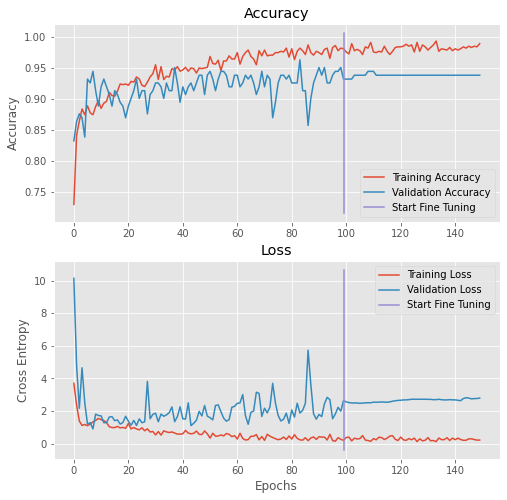

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/4 [======>.......................] - ETA: 0s - loss: 5.0458 - accuracy: 0.8516

2/4 [==============>...............] - ETA: 1s - loss: 3.4722 - accuracy: 0.8906

3/4 [=====================>........] - ETA: 1s - loss: 2.4384 - accuracy: 0.9193

4/4 [==============================] - ETA: 0s - loss: 2.1618 - accuracy: 0.9303

4/4 [==============================] - 5s 1s/step - loss: 2.1618 - accuracy: 0.9303


[2.161792516708374, 0.9303278923034668]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.930327868852459
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       148
           1       0.94      0.96      0.95       340

    accuracy                           0.93       488
   macro avg       0.93      0.91      0.92       488
weighted avg       0.93      0.93      0.93       488



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

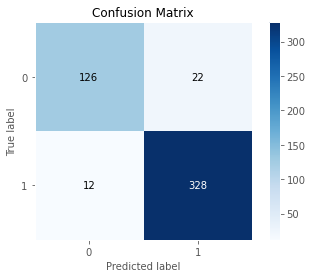

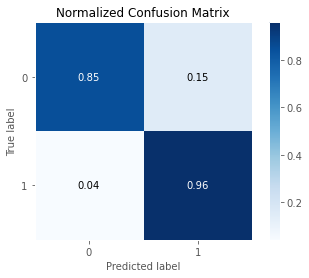

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

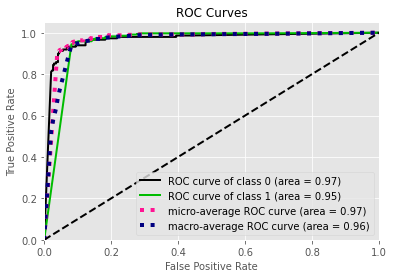

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       148
           1       0.94      0.96      0.95       340

    accuracy                           0.93       488
   macro avg       0.93      0.91      0.92       488
weighted avg       0.93      0.93      0.93       488

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.85      0.96      0.88      0.91      0.81       148
          1       0.94      0.96      0.85      0.95      0.91      0.83       340

avg / total       0.93      0.93      0.89      0.93      0.91      0.82       488

